# Base Uniswap actively traded ATH index

- Cross validation for Binance Smart Chain and PancakeSwap

# Set up

Set up Trading Strategy data client.


In [51]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)

# set_notebook_logging()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [52]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "08-bnb-cross-validation"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #s
    # See list here: TODO
    #
    chain_id = ChainId.binance
    exchanges = {"pancakeswap-v2"}
    
    #
    # Basket construction and rebalance parameters
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 10  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    # ATH indicator parameters
    ath_delay_bars = 144
    ath_window_bars = 360
    ath_threshold = 1.10
    ath_span = 72

    # RSI filter parameters
    daily_rsi_bars = 90
    daily_rsi_threshold = 25
    
    # For the length of trailing sharpe used in inclusion criteria
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_volatility_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    tvl_ewm_span = 7 * 24  # Smooth TVL inclusin criteria
    min_volume = 50_000   # USD
    min_tvl = 1_000_000  # USD - set to same as above if you want to avoid any survivorship bias
    min_tvl_prefilter = 1_000_000  # USD - to reduce number of trading pairs for backtest-purposes only
    min_token_sniffer_score = 20  # 20 = AAVE

    #
    # Yield on cash
    #
    use_aave = False
    credit_flow_dust_threshold = 5.0  # Min deposit USD to Aave

    #     
    #
    # Backtesting only
    # Limiting factor: Aave v3 on Base starts at the end of DEC 2023
    #
    backtest_start = datetime.datetime(2022, 1, 1)
    backtest_end = datetime.datetime(2025, 3, 13)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Chain configuration

- Configure different chain parameters
- Allows us to hop between different chains easily in the same notebook

In [53]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.lending import LendingProtocolType


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
        "cbBTC"
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v2", "WETH", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "AAVE",
        "WETH",
        "WBTC",
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.binance:
    SUPPORTING_PAIRS = [
        (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
        (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WBNB",
        "FTC",
        "TRUNK",
        # "CUMMIES",
    ]

    VOL_PAIR = (Parameters.chain_id, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

    LENDING_RESERVES = None

    PREFERRED_STABLECOIN = USDT_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.avalanche:
    SUPPORTING_PAIRS = [
        (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030),  
        (ChainId.avalanche, "trader-joe", "WETH.e", "WAVAX", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WAVAX",
        "JOE",
        "WETH.e",
    ]

    VOL_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030)

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

    LENDING_RESERVES = None    

else:
    raise NotImplementedError(f"Chain not supported: {parameters.chain_id}")

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [54]:
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client


from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score



from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe



def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id

    print(f"Preparing trading universe on chain {chain_id.get_name()}")

    exchange_universe = client.fetch_exchange_universe()
    targeted_exchanges = [exchange_universe.get_by_chain_and_slug(chain_id, slug) for slug in Parameters.exchanges]
    
    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    all_pairs_df = filter_for_exchange_slugs(all_pairs_df, Parameters.exchanges)
    print("Creating universe for benchmark pair extraction")
    pair_universe = PandasPairUniverse(
        all_pairs_df, 
        exchange_universe=exchange_universe,
        build_index=False,
    )
    print(f"Exchanges {Parameters.exchanges} have total {len(all_pairs_df):,} pairs on chain {Parameters.chain_id.get_name()}")

    # Get TVL data for prefilteirng
    if execution_context.live_trading:
        # For live trading, we take TVL data from ~around the start of the strategy until today
        tvl_time_bucket = TimeBucket.d1
        start = datetime.datetime(2024, 2, 1)
        end = tvl_time_bucket.floor(pd.Timestamp(datetime.datetime.utcnow() - tvl_time_bucket.to_timedelta))
    else:
        start = Parameters.backtest_start
        end = Parameters.backtest_end

    #
    # Do exchange and TVL prefilter pass for the trading universe
    #
    min_tvl = Parameters.min_tvl_prefilter
    # logging.getLogger().setLevel(logging.INFO)
    liquidity_time_bucket = TimeBucket.d1
    tvl_df = client.fetch_tvl(
        mode="min_tvl_low",
        bucket=liquidity_time_bucket,
        start_time=start,
        end_time=end,
        exchange_ids=[exc.exchange_id for exc in targeted_exchanges],
        min_tvl=min_tvl,
    )
    # logging.getLogger().setLevel(logging.WARNING)
    print(f"Fetch TVL, we got {len(tvl_df['pair_id'].unique())} pairs with TVL data for min TVL criteria {min_tvl}")

    tvl_filtered_pair_ids = tvl_df["pair_id"].unique()
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]
    needed_pair_ids = set(benchmark_pair_ids) | set(tvl_filtered_pair_ids)
    pairs_df = all_pairs_df[all_pairs_df["pair_id"].isin(needed_pair_ids)]
    print(f"After TVL prefilter to {Parameters.min_tvl_prefilter:,} in {Parameters.backtest_start} - {Parameters.backtest_end}, we have {len(pairs_df)} trading pairs")
    pairs_df = add_base_quote_address_columns(pairs_df)

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    allowed_quotes = {
        PREFERRED_STABLECOIN,
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }
    filtered_pairs_df = filter_pairs_default(
        pairs_df,
        good_quote_token_addresses=allowed_quotes,
        verbose_print=print,
    )

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(filtered_pairs_df)

    # Get our reference pairs back to the dataset
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')
    print(f"After deduplication we have {len(pairs_df)} pairs")

    # Add benchmark pairs back to the dataset
    pairs_df = pd.concat([pairs_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Load metadata
    print("Loading metadata")
    # logging.getLogger().setLevel(logging.INFO)
    pairs_df = load_token_metadata(pairs_df, client)
    # logging.getLogger().setLevel(logging.WARNING)

    # Scam filter using TokenSniffer
    risk_filtered_pairs_df = filter_by_token_sniffer_score(
        pairs_df,
        risk_score=Parameters.min_token_sniffer_score,
        drop_tokens_with_missing_data=False,
    )

    # Check if we accidentally get rid of benchmark pairs we need for the strategy
    difference = set(benchmark_pair_ids).difference(set(risk_filtered_pairs_df["pair_id"]))
    if difference:
        first_dropped_id = next(iter(difference))
        first_dropped_data = pairs_df.loc[pairs_df.pair_id == first_dropped_id]
        assert len(first_dropped_data) == 1, f"Got {len(first_dropped_data)} entries: {first_dropped_data}"
        raise AssertionError(f"Benchmark trading pair dropped in filter_by_token_sniffer_score() check: {first_dropped_data.iloc[0]}")
    pairs_df = risk_filtered_pairs_df.sort_values("volume", ascending=False)
    print(f"After TokenSniffer risk filter we have {len(pairs_df)} pairs")

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    other_dex = pairs_df.loc[~((pairs_df["exchange_slug"] != "uniswap-v3") | (pairs_df["exchange_slug"] != "uniswap-v2"))]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}, other DEX: {len(other_dex)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity_time_bucket=liquidity_time_bucket,
        preloaded_tvl_df=tvl_df,
        lending_reserves=LENDING_RESERVES,    
    )

    reserve_asset = PREFERRED_STABLECOIN

    print("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    print(f"Total {strategy_universe.get_pair_count()}")

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
)


Preparing trading universe on chain BNB Smart Chain
Creating universe for benchmark pair extraction
Exchanges {'pancakeswap-v2'} have total 158,270 pairs on chain BNB Smart Chain
Fetch TVL, we got 1545 pairs with TVL data for min TVL criteria 1000000
After TVL prefilter to 1,000,000 in 2022-01-01 00:00:00 - 2025-03-13 00:00:00, we have 1538 trading pairs
Pairs in the input dataset 1538
Pairs having a good fee 1538
Pairs that are not stable-stable 1523
Pairs that are not derivative tokens 1520
Pairs that are not rebase tokens 1520
Pairs with good quote token 1353
Pairs with clean ASCII token name 1350
After deduplication we have 985 pairs
Loading metadata
After TokenSniffer risk filter we have 201 pairs
Pairs on Uniswap v2: 0, Uniswap v3: 0, other DEX: 0
Creating trading universe
2025-03-19 14:48:13,414 tradingstrategy.utils.groupeduniverse              WARNING  GroupedLiquidityUniverse: auto-heal pair limit 1500 exceeded with 1545 pairs
Total 201
Universe creation done


base quote        exchange  fee %   type:        price  \
id                                                                        
2460502         10SET  WBNB  pancakeswap-v2   0.25  traded         0.07   
1966896         2022M  WBNB  pancakeswap-v2   0.25  traded         0.00   
1364767           ADA  WBNB  pancakeswap-v2   0.25  traded         0.73   
3007784           AGI  USDT  pancakeswap-v2   0.25  traded         0.05   
1370510          AIOZ  WBNB  pancakeswap-v2   0.25  traded         0.26   
1364941         ALICE  WBNB  pancakeswap-v2   0.25  traded         0.52   
1364811         ALPHA  WBNB  pancakeswap-v2   0.25  traded         0.04   
1387782           ALU  WBNB  pancakeswap-v2   0.25  traded         0.04   
2505881           APC  USDT  pancakeswap-v2   0.25  traded         0.00   
2085156           APX  WBNB  pancakeswap-v2   0.25  traded         0.05   
2822936           ASN  USDT  pancakeswap-v2   0.25  traded         0.00   
1724535           AXS  WBNB  pancakeswap-v2   0.25  traded         3.18   
1873071         BCOIN  WBNB  pancakeswap-v2   0.25  traded         0.01   
1364935          BELT  WBNB  pancakeswap-v2   0.25  traded         0.04   
2738698          BGVT  WBNB  pancakeswap-v2   0.25  traded         0.00   
2696651        BITNEY  USDT  pancakeswap-v2   0.25  traded         0.00   
1603531          BMON  WBNB  pancakeswap-v2   0.25  traded         0.00   
1529468           BOG  WBNB  pancakeswap-v2   0.25  traded         0.01   
1691693         BRISE  WBNB  pancakeswap-v2   0.25  traded         0.00   
1369371        BSCPAD  WBNB  pancakeswap-v2   0.25  traded         0.02   
1372676          BSCS  WBNB  pancakeswap-v2   0.25  traded         0.00   
1498640           BSW  WBNB  pancakeswap-v2   0.25  traded         0.03   
1364798          BTCB  WBNB  pancakeswap-v2   0.25  traded     83570.91   
1364865         BTCST  WBNB  pancakeswap-v2   0.25  traded         0.03   
3458569      BabyBonk  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1484344      BabyDoge  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
3409516      BabyGrok  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1646549  BabyShibaInu  WBNB  pancakeswap-v2   0.25  traded         0.00   
3620380       Bin4nce  WBNB  pancakeswap-v2   0.25  traded         0.00   
3411209    Black Hole  USDT  pancakeswap-v2   0.25  traded         0.01   
1743235           C98  WBNB  pancakeswap-v2   0.25  traded         0.07   
4308732           CAT  WBNB  pancakeswap-v2   0.25  traded         0.00   
3631978          CATA  WBNB  pancakeswap-v2   0.25  traded         0.00   
1684215          CATE  WBNB  pancakeswap-v2   0.25  traded         0.00   
1527334       CATGIRL  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1700312          CBET  WBNB  pancakeswap-v2   0.25  traded         0.00   
1709242          CEEK  WBNB  pancakeswap-v2   0.25  traded         0.02   
1998420          CENX  WBNB  pancakeswap-v2   0.25  traded         0.00   
3827984          COCO  USDT  pancakeswap-v2   0.25  traded         0.00   
1778472            CP  USDT  pancakeswap-v2   0.25  traded         0.00   
1633257           CWT  WBNB  pancakeswap-v2   0.25  traded         0.00   
1364759          Cake  WBNB  pancakeswap-v2   0.25  traded         1.56   
4385338        Cheems  WBNB  pancakeswap-v2   0.25  traded         0.00   
3483287            DA  WBNB  pancakeswap-v2   0.25  traded       219.80   
2500300           DAO  USDT  pancakeswap-v2   0.25  traded         0.02   
1949508           DAR  WBNB  pancakeswap-v2   0.25  traded         0.12   
4374900          DBTC  USDT  pancakeswap-v2   0.25  traded      1052.13   
3422047           DCB  USDT  pancakeswap-v2   0.25  traded         0.01   
4584194           DCT  USDT  pancakeswap-v2   0.25  traded         0.09   
1365074          DEGO  WBNB  pancakeswap-v2   0.25  traded         0.01   
1422955          DERI  WBNB  pancakeswap-v2   0.25  traded         0.01   
2413972         DIAOS  USDT  pancakeswap-v

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [55]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 200 assets
Category trading pairs 201
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [56]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def ath(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
) -> pd.Series:
    """All time high indicator.

    - Calculate % we are above all time high

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    shifted = close.shift(ath_delay_bars)
    windowed = shifted.rolling(
        window=ath_window_bars, 
        min_periods=ath_window_bars,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def volatility(close: pd.Series, rolling_volatility_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rolling_volatility_bars).std()
    return rolling_std


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(dependencies=(volatility,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rolling_volatility_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rolling_volatility_bars": rolling_volatility_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility



@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close, execution_context) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))

    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series


    return daily_df


@indicators.define(source=IndicatorSource.dependencies_only_per_pair, dependencies=[daily_price])
def daily_rsi(
    daily_rsi_bars,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
):
    daily_close = dependency_resolver.get_indicator_data(
        "daily_price",
        pair=pair,
        column="close",
    )
    rsi_series = pandas_ta.rsi(
        daily_close,
        length=daily_rsi_bars,
    )

    if rsi_series is None:        
        return empty_series
    
    return rsi_series



@indicators.define(dependencies=[ath, ath, daily_rsi])
def signal(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,
    daily_rsi_bars: int,
    daily_rsi_threshold: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Combine ATH signal with daily RSI filter.
    
    - We use daily RSI filter to get rid of crap pairs like FTC
    """

    rsi = dependency_resolver.get_indicator_data(
        "daily_rsi",
        parameters={"daily_rsi_bars": daily_rsi_bars},
        pair=pair,
    )

    # Set default RSI value so we include pairs
    # without enough history
    rsi = rsi.fillna(50).infer_objects(copy=False)

    ath = dependency_resolver.get_indicator_data(
        "ath",
        parameters={
            "ath_delay_bars": ath_delay_bars,
            "ath_window_bars": ath_window_bars,
        },
        pair=pair,
    )
    ath_core = ath.ewm(span=ath_span).mean() - ath_threshold

    # Use daily RSI as a thrash filter
    # See FTC: https://tradingstrategy.ai/trading-view/binance/pancakeswap-v2/ftc-usdt
    df = pd.DataFrame({
        "rsi": rsi,
        "ath_core": ath_core,
    })
    # forward-fill from daily to hourly
    # SHOULD handle forward fill until the live timestamp
    df["rsi"] = df["rsi"].infer_objects(copy=False).ffill()
    mask = df.rsi >= daily_rsi_threshold

    df['ath_thresholded'] = 0.0  # Initialize with zeros
    df.loc[mask, 'ath_thresholded'] = df.loc[mask, 'ath_core']  # Copy ATH indicator values from non-masked timestamps
    return df["ath_thresholded"]



@indicators.define(dependencies=(signal,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,    
    daily_rsi_bars: int,
    daily_rsi_threshold: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate our "signal" across all pairs.

    - Use median - mean is skewed by outliers

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        "signal",
        parameters={
            "ath_window_bars": ath_window_bars,
            "ath_delay_bars": ath_delay_bars,
            "ath_threshold": ath_threshold,
            "ath_span": ath_span,
            "daily_rsi_bars": daily_rsi_bars,
            "daily_rsi_threshold": daily_rsi_threshold,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).median()
    
    return cleaned_avg_signal


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 19 indicators:


Reading cached indicators ath, volatility, rolling_cumulative_volume, rolling_liquidity_avg, volume_inclusion_…

Using indicator cache /Users/moo/.cache/indicators/binance_1h_201_2022-01-01-2025-03-13_ff


# Available pairs

- Number of pairs available to trade every month



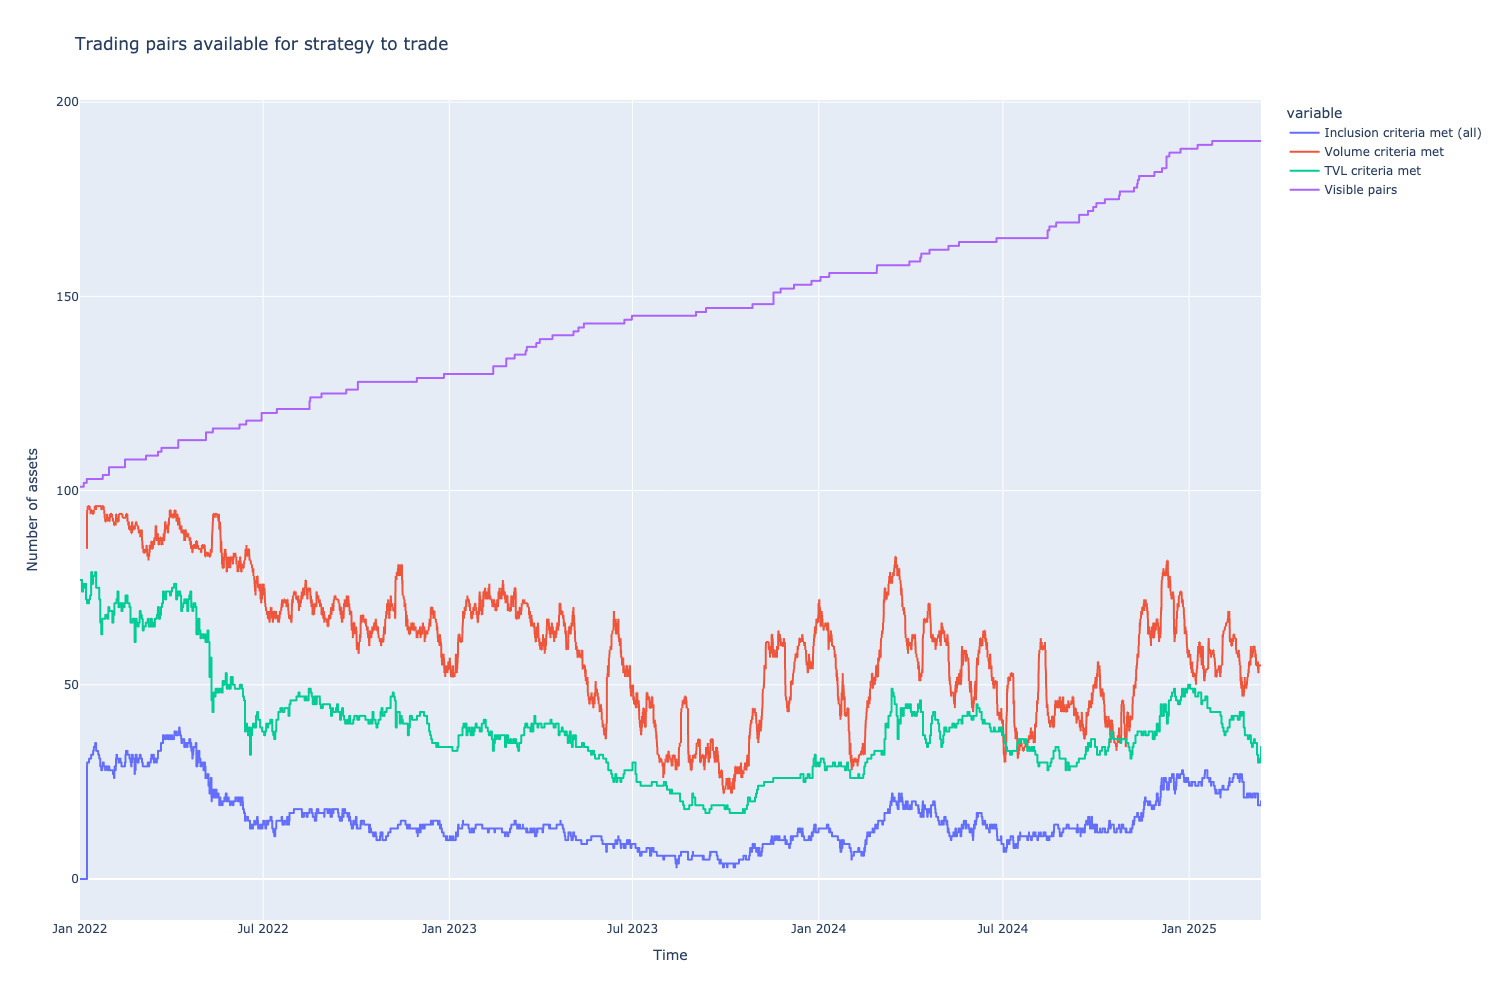

Inclusion criteria met (all)  Volume criteria met  \
2025-03-12 20:00:00                            19                 55.0   
2025-03-12 21:00:00                            19                 55.0   
2025-03-12 22:00:00                            19                 55.0   
2025-03-12 23:00:00                            19                 55.0   
2025-03-13 00:00:00                            20                 55.0   

                     TVL criteria met  Visible pairs  
2025-03-12 20:00:00                31            190  
2025-03-12 21:00:00                31            190  
2025-03-12 22:00:00                31            190  
2025-03-12 23:00:00                31            190  
2025-03-13 00:00:00                34            190

In [57]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for strategy to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [58]:
from tradingstrategy.liquidity import LiquidityDataUnavailable

series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

def _get_ticker(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).get_ticker()
    except Exception:
        return "<pair metadata missing>"
    
def _get_dex(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).exchange_name
    except Exception:
        return "<DEX metadata missing>"

df["Ticker"] = first_appearance_series.index.map(_get_ticker)
df["DEX"] = first_appearance_series.index.map(_get_dex)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    try:
        tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
            pair_id,
            timestamp,
            tolerance=pd.Timedelta(days=2),
        )
        return tvl
    except LiquidityDataUnavailable:
        # TODO Data dates mismatch?
        return 0 
    
def _map_tvl_end(row):
    pair_id = row.name  # Indxe
    timestamp = Parameters.backtest_end
    try:
        tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
            pair_id,
            timestamp,
            tolerance=pd.Timedelta(days=2),
        )
        return tvl
    except LiquidityDataUnavailable:
        # TODO Data dates mismatch?
        return 0 

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["TVL at end"] = df.apply(_map_tvl_end, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 109 trading pairs, when they meet all inclusion criteria:


Included at             Ticker             DEX  \
1364759 2022-01-07 23:00:00          Cake-WBNB  pancakeswap-v2   
1743235 2022-01-07 23:00:00           C98-WBNB  pancakeswap-v2   
1759053 2022-01-07 23:00:00           SPS-WBNB  pancakeswap-v2   
1684215 2022-01-07 23:00:00          CATE-WBNB  pancakeswap-v2   
1678885 2022-01-07 23:00:00      MiniDOGE-WBNB  pancakeswap-v2   
1634297 2022-01-07 23:00:00          NFTB-WBNB  pancakeswap-v2   
1836298 2022-01-07 23:00:00          TCG2-WBNB  pancakeswap-v2   
1529468 2022-01-07 23:00:00           BOG-WBNB  pancakeswap-v2   
1499861 2022-01-07 23:00:00    PORNROCKET-WBNB  pancakeswap-v2   
1858849 2022-01-07 23:00:00       ETERNAL-WBNB  pancakeswap-v2   
1473937 2022-01-07 23:00:00      HOTCROSS-WBNB  pancakeswap-v2   
1447002 2022-01-07 23:00:00        YOOSHI-WBNB  pancakeswap-v2   
1429476 2022-01-07 23:00:00           SYA-WBNB  pancakeswap-v2   
1700312 2022-01-07 23:00:00          CBET-WBNB  pancakeswap-v2   
1402762 2022-01-07 23:00:00          DOBO-WBNB  pancakeswap-v2   
1885076 2022-01-07 23:00:00         LIGHT-WBNB  pancakeswap-v2   
1949508 2022-01-07 23:00:00           DAR-WBNB  pancakeswap-v2   
1364794 2022-01-07 23:00:00           XVS-WBNB  pancakeswap-v2   
1364798 2022-01-07 23:00:00          BTCB-WBNB  pancakeswap-v2   
1949293 2022-01-07 23:00:00           PEX-WBNB  pancakeswap-v2   
1364941 2022-01-07 23:00:00         ALICE-WBNB  pancakeswap-v2   
1365083 2022-01-07 23:00:00           TKO-WBNB  pancakeswap-v2   
1724535 2022-01-07 23:00:00           AXS-WBNB  pancakeswap-v2   
2041990 2022-01-07 23:00:00          SPIN-WBNB  pancakeswap-v2   
1368114 2022-01-07 23:00:00          DOGE-WBNB  pancakeswap-v2   
2006115 2022-01-07 23:00:00           MEB-USDT  pancakeswap-v2   
1950014 2022-01-07 23:00:00          GMEX-WBNB  pancakeswap-v2   
2061769 2022-01-07 23:00:00           NYF-WBNB  pancakeswap-v2   
1768449 2022-01-08 00:00:00          POSI-WBNB  pancakeswap-v2   
2115013 2022-01-08 01:00:00           REV-WBNB  pancakeswap-v2   
2124658 2022-01-10 00:00:00           QJI-USDT  pancakeswap-v2   
1626541 2022-01-12 00:00:00          MINT-WBNB  pancakeswap-v2   
1605057 2022-01-14 00:00:00           WOO-WBNB  pancakeswap-v2   
1364935 2022-01-14 16:00:00          BELT-WBNB  pancakeswap-v2   
1633953 2022-01-16 00:00:00       THOREUM-WBNB  pancakeswap-v2   
2159496 2022-01-23 12:00:00         FLOKI-WBNB  pancakeswap-v2   
1897404 2022-01-26 00:00:00           ROO-USDT  pancakeswap-v2   
2081782 2022-02-04 00:00:00      DogeKing-WBNB  pancakeswap-v2   
1759545 2022-02-05 14:00:00          JOJO-WBNB  pancakeswap-v2   
2216839 2022-02-14 10:00:00          URUS-WBNB  pancakeswap-v2   
1704251 2022-02-21 09:00:00           NFT-WBNB  pancakeswap-v2   
1691693 2022-02-25 00:00:00         BRISE-WBNB  pancakeswap-v2   
2266676 2022-03-12 13:00:00          TINC-WBNB  pancakeswap-v2   
2298934 2022-03-19 02:00:00       SpacePi-WBNB  pancakeswap-v2   
2209190 2022-03-24 00:00:00          MILO-WBNB  pancakeswap-v2   
1498640 2022-03-24 00:00:00           BSW-WBNB  pancakeswap-v2   
2350726 2022-04-08 03:00:00           TAU-USDT  pancakeswap-v2   
1367145 2022-04-12 00:00:00      ElonGate-WBNB  pancakeswap-v2   
1603531 2022-04-17 06:00:00          BMON-WBNB  pancakeswap-v2   
2460502 2022-06-07 14:00:00         10SET-WBNB  pancakeswap-v2   
2500300 2022-07-22 00:00:00           DAO-USDT  pancakeswap-v2   
2582981 2022-08-15 20:00:00           UVT-USDT  pancakeswap-v2   
1688868 2022-08-22 19:00:00          HERO-WBNB  pancakeswap-v2   
1364896 2022-08-23 12:00:00           SFP-WBNB  pancakeswap-v2   
2500052 2022-11-11 03:00:00        SEAMAN-USDT  pancakeswap-v2   
2664170 2022-11-13 00:00:00            QJ-USDT  pancakeswap-v2   
1364863 2022-11-22 00:00:00           LTC-WBNB  pancakeswap-v2   
2085156 2023-03-02 00:00:00           APX-WBNB  pancakeswap-v2   
2933834 2023-03-03 05:00:00           WOR-USDT  pancakeswap-v2   
1646549 2023-03-06 08:00:00  BabyShibaInu-WBNB  pancakes

# Signal across pairs

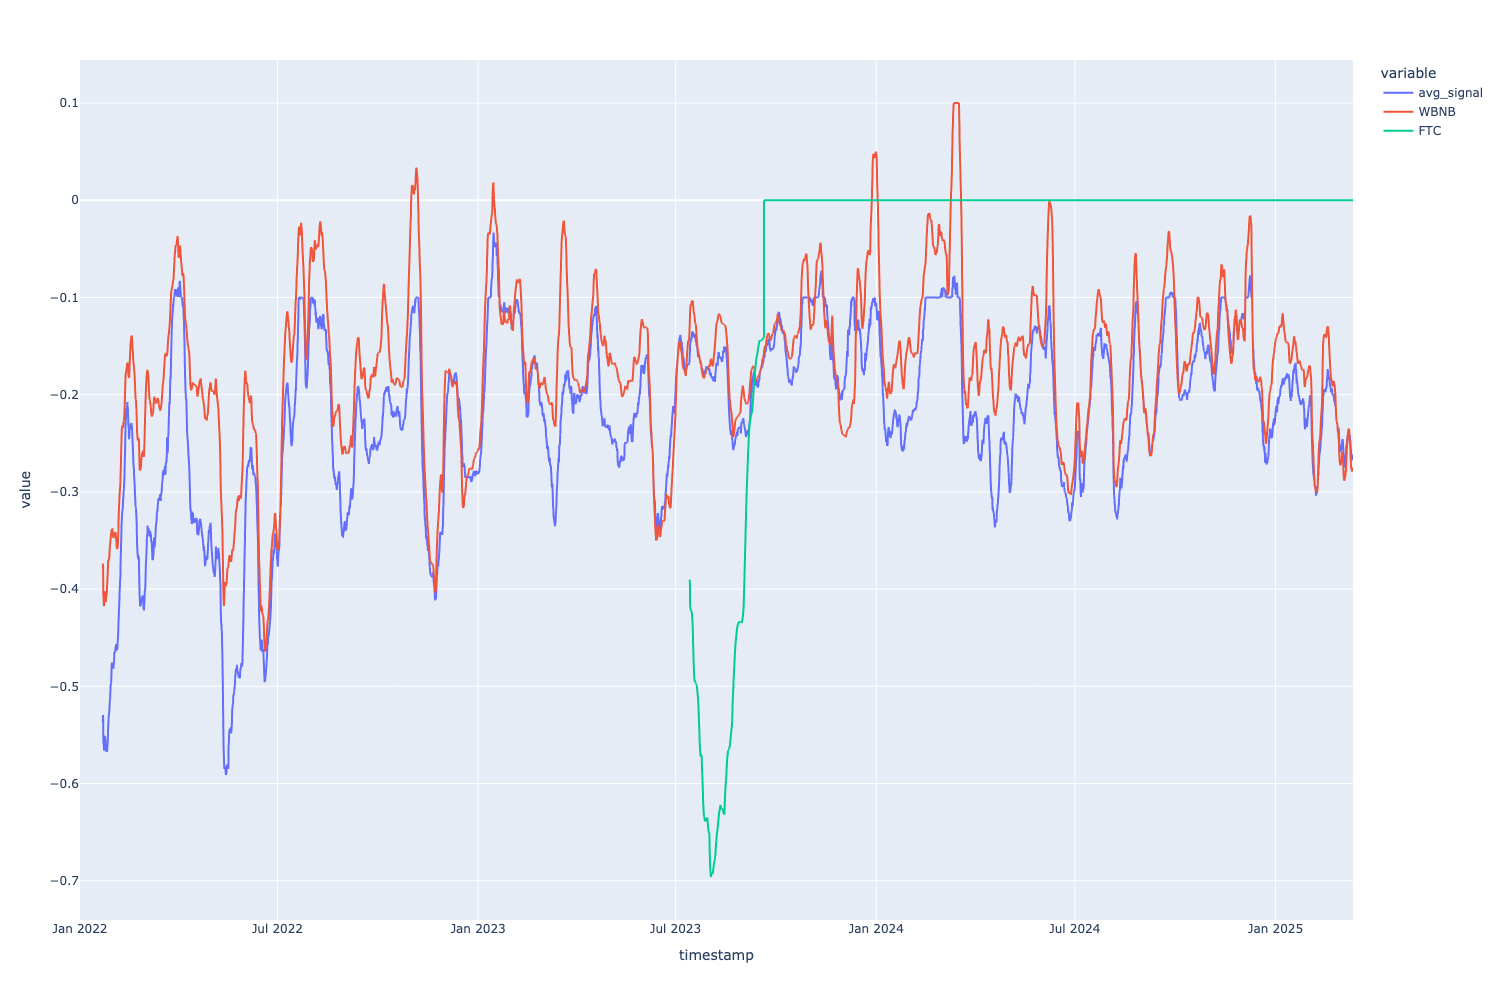

In [59]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# max_displayed_vol = avg_signal.max() * 1.1
upper_displayed = 0.1

avg_signal = indicator_data.get_indicator_series("avg_signal")

data = {
    "avg_signal": avg_signal.clip(upper=upper_displayed),
}


# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    signal = indicator_data.get_indicator_series("signal", pair=pair)
    signal = signal.clip(upper=upper_displayed)
    data[symbol] = signal
    
df = pd.DataFrame(data)
fig = px.line(df)
fig.show()


# Volatility across pairs

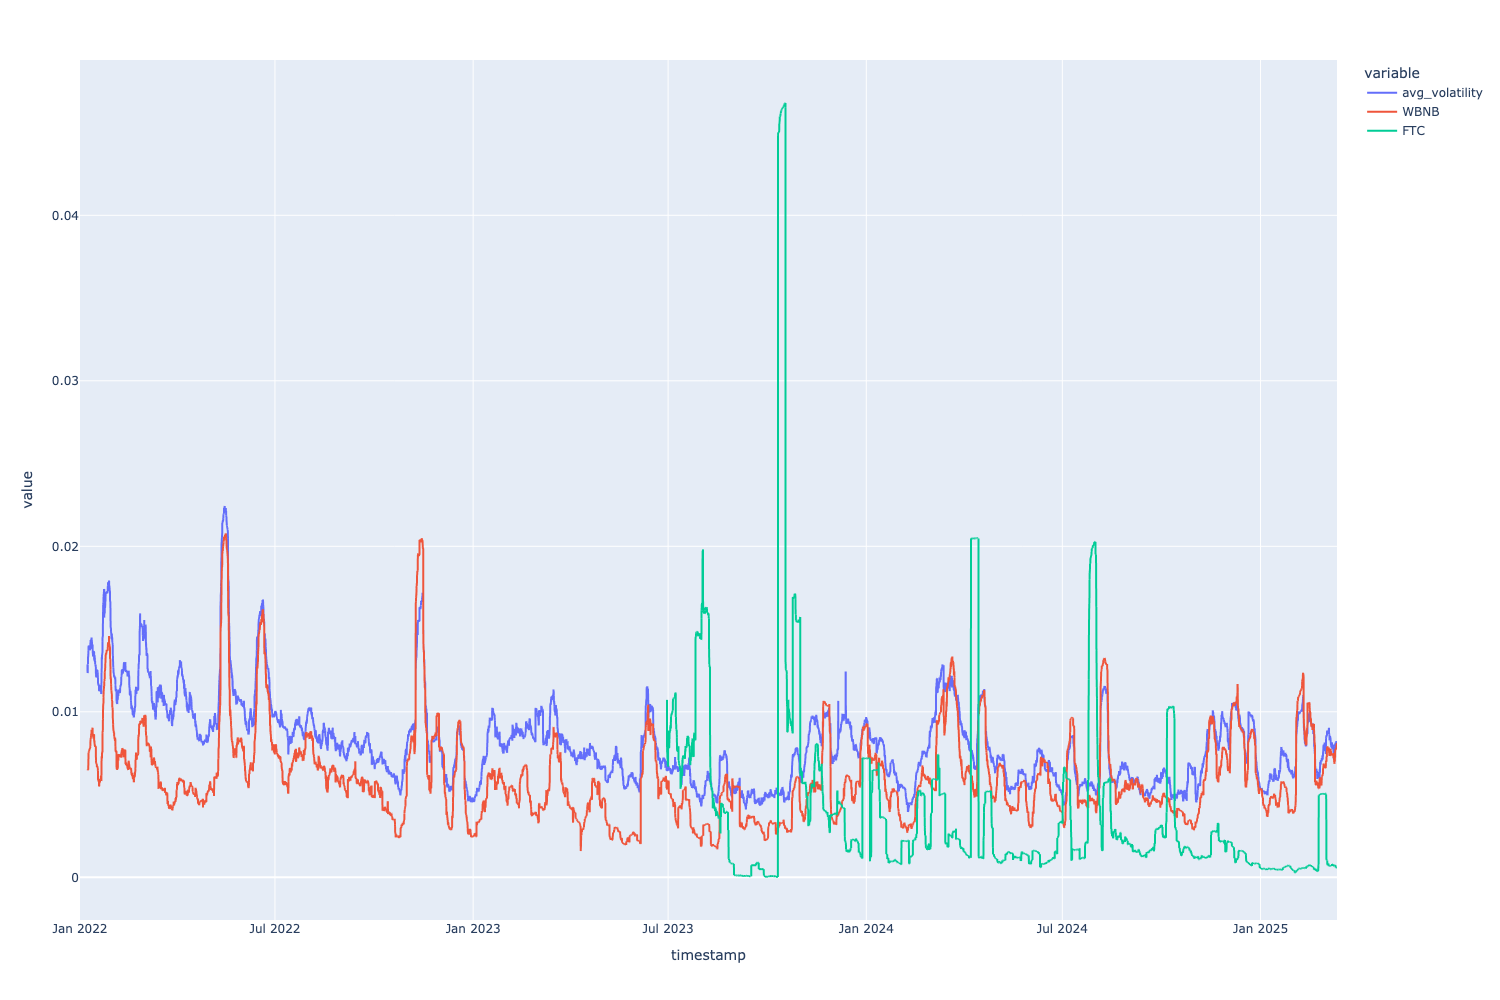

In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

avg_volatility = indicator_data.get_indicator_series("avg_volatility")

volatilities = {
    "avg_volatility": avg_volatility,
}

max_displayed_vol = avg_volatility.max() * 3

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)
    volatility = volatility.clip(upper=max_displayed_vol)
    volatilities[symbol] = volatility
    
volatility_df = pd.DataFrame(volatilities)
fig = px.line(volatility_df)
fig.show()


# Price vs. signal

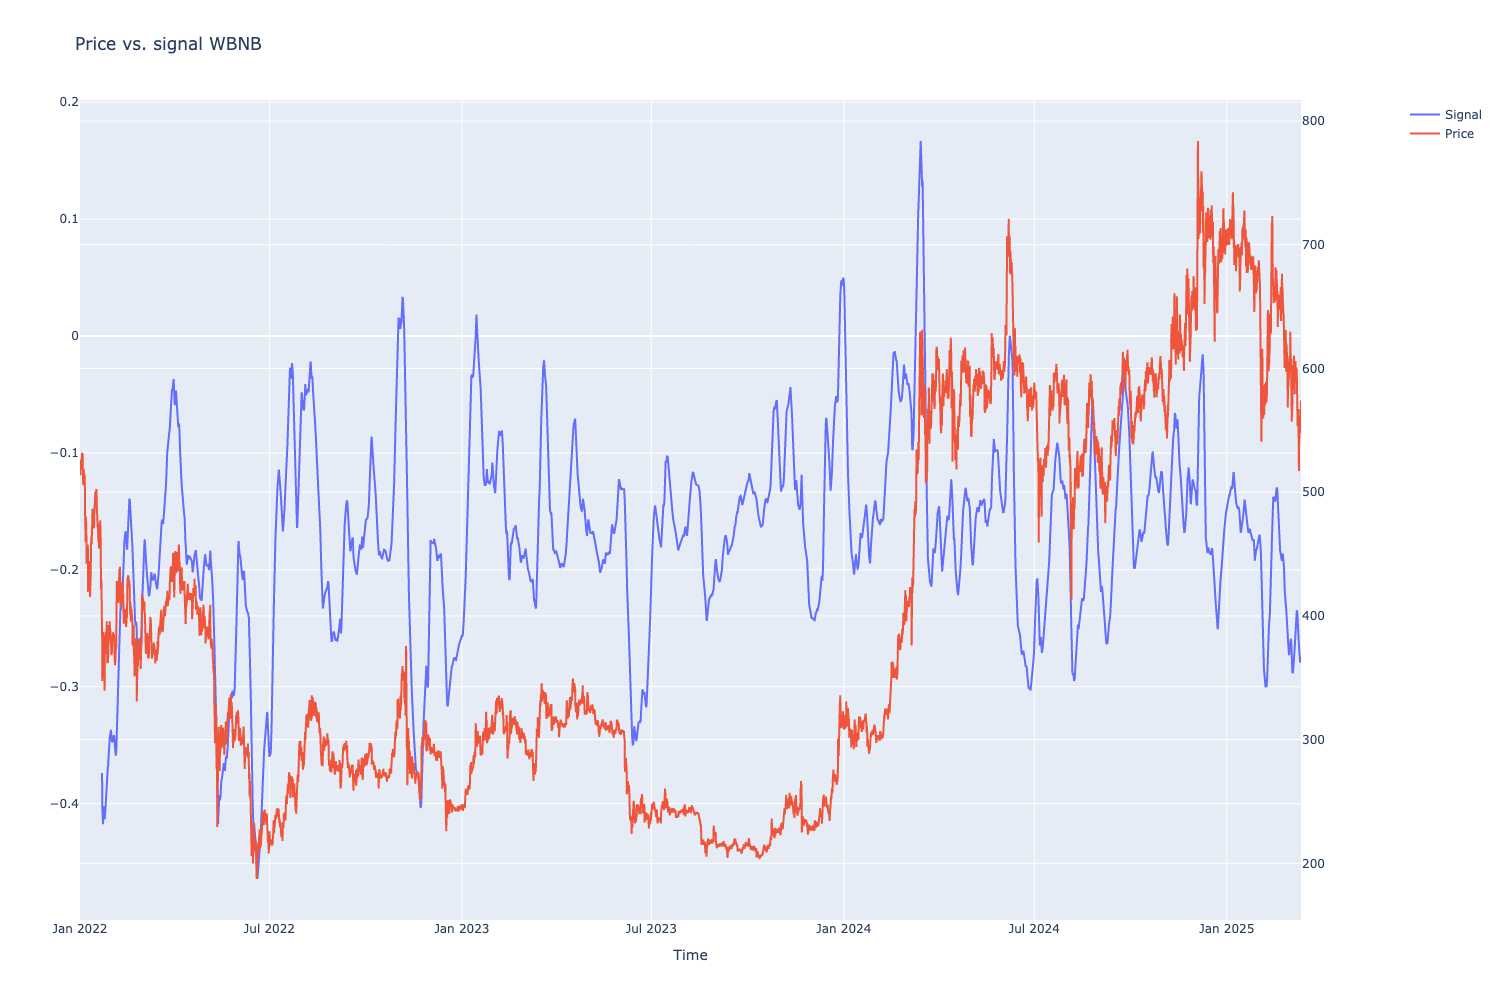

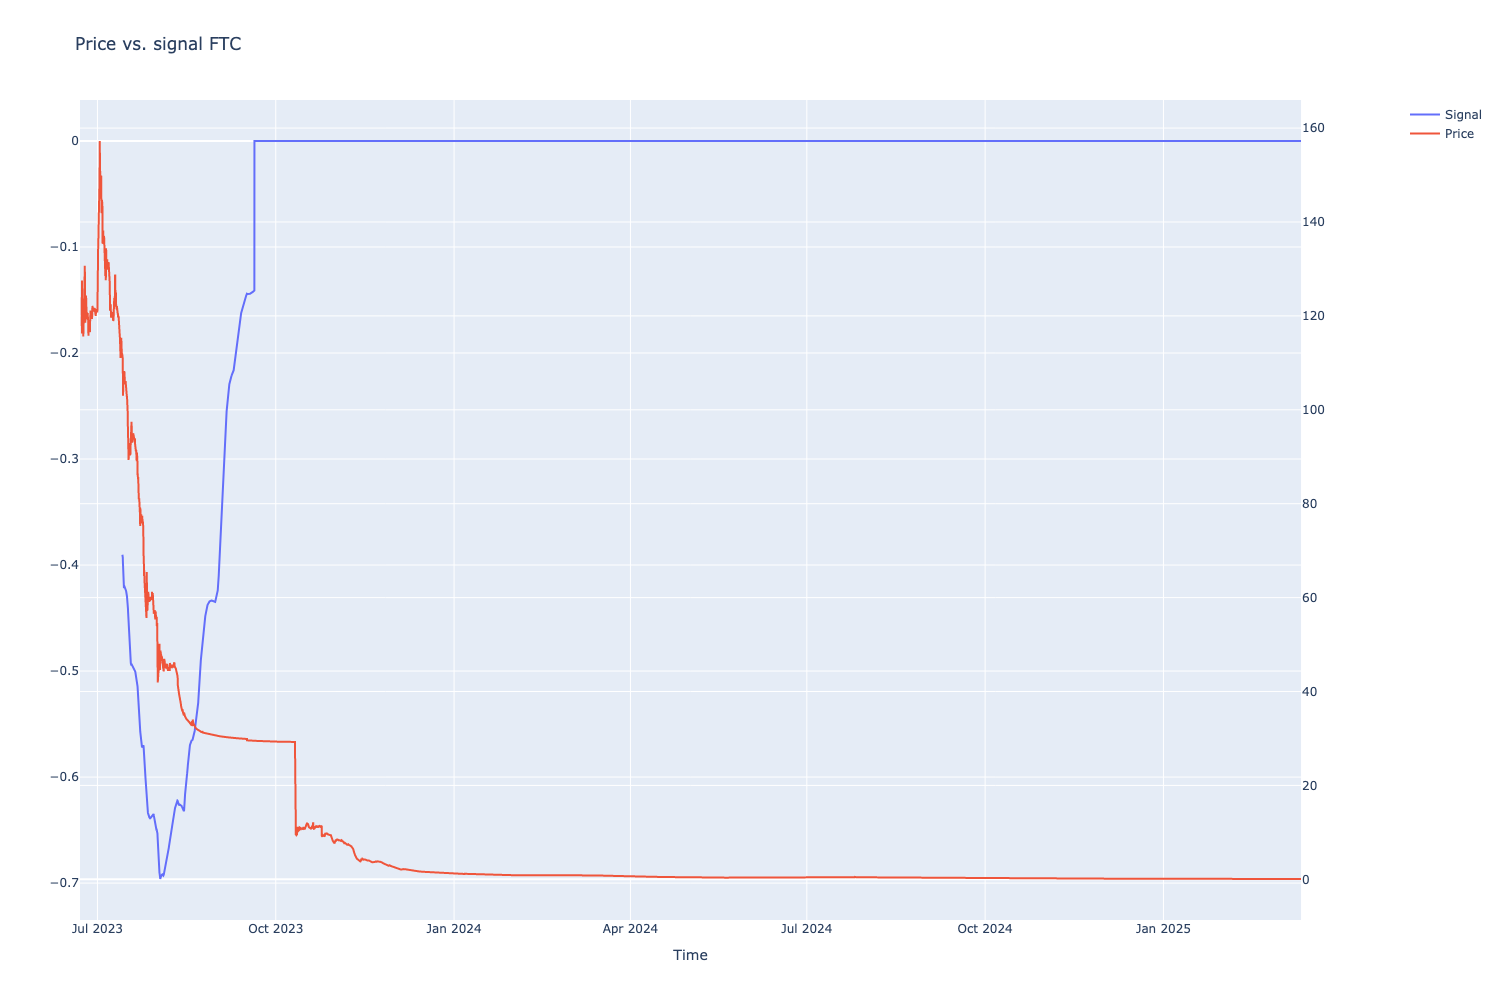

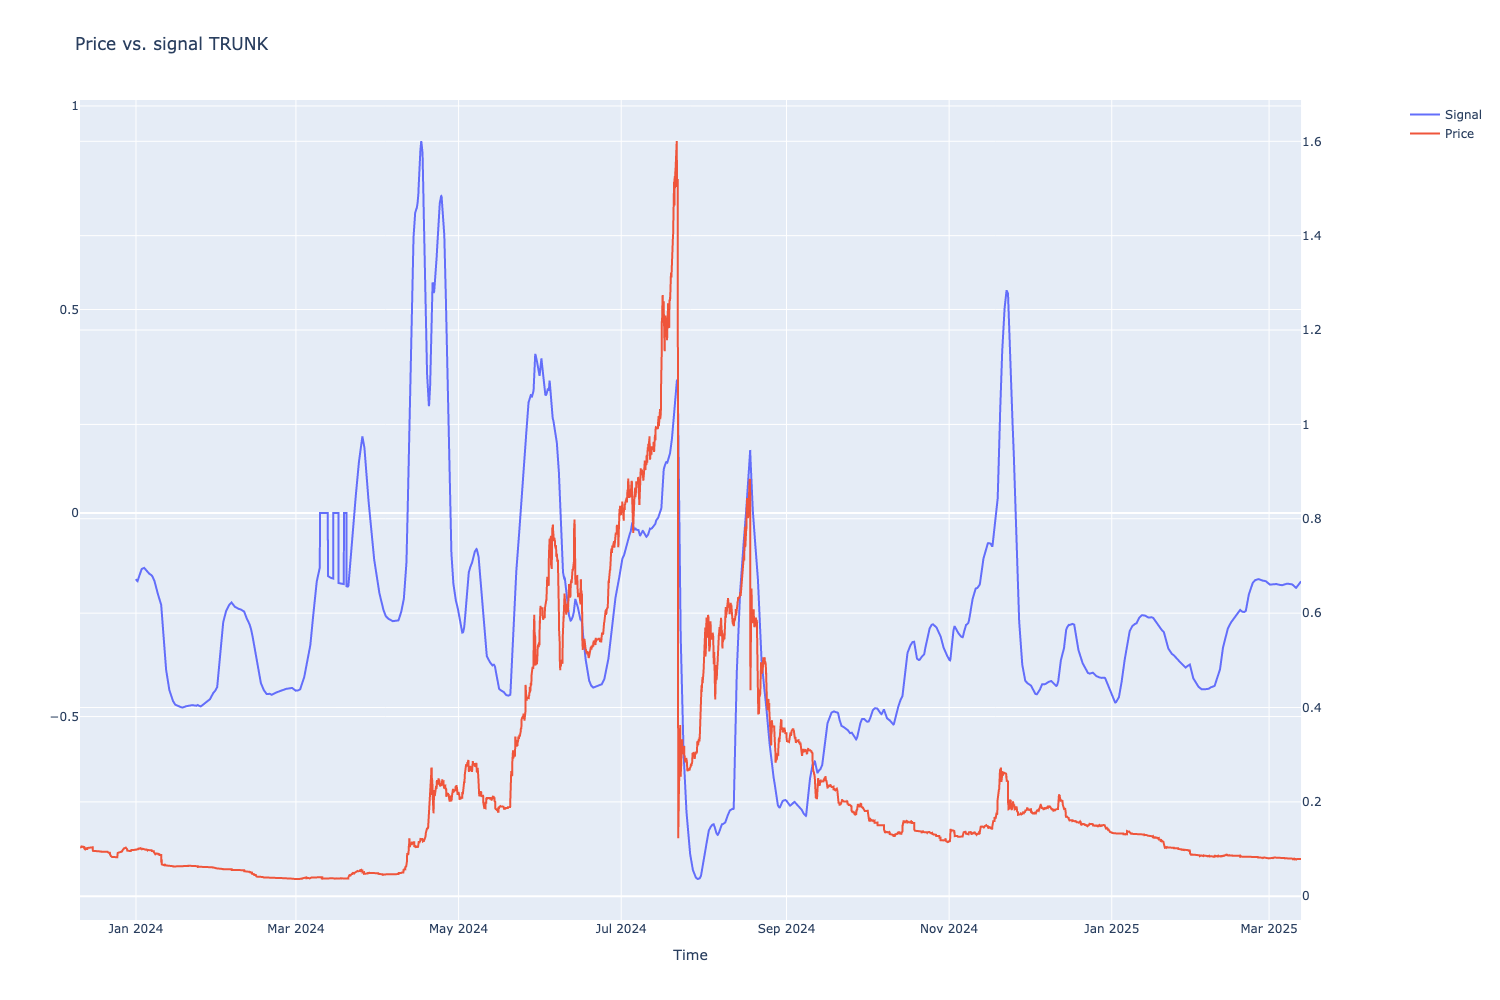

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("signal", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. ATH indicator

- Plot ATH indicator

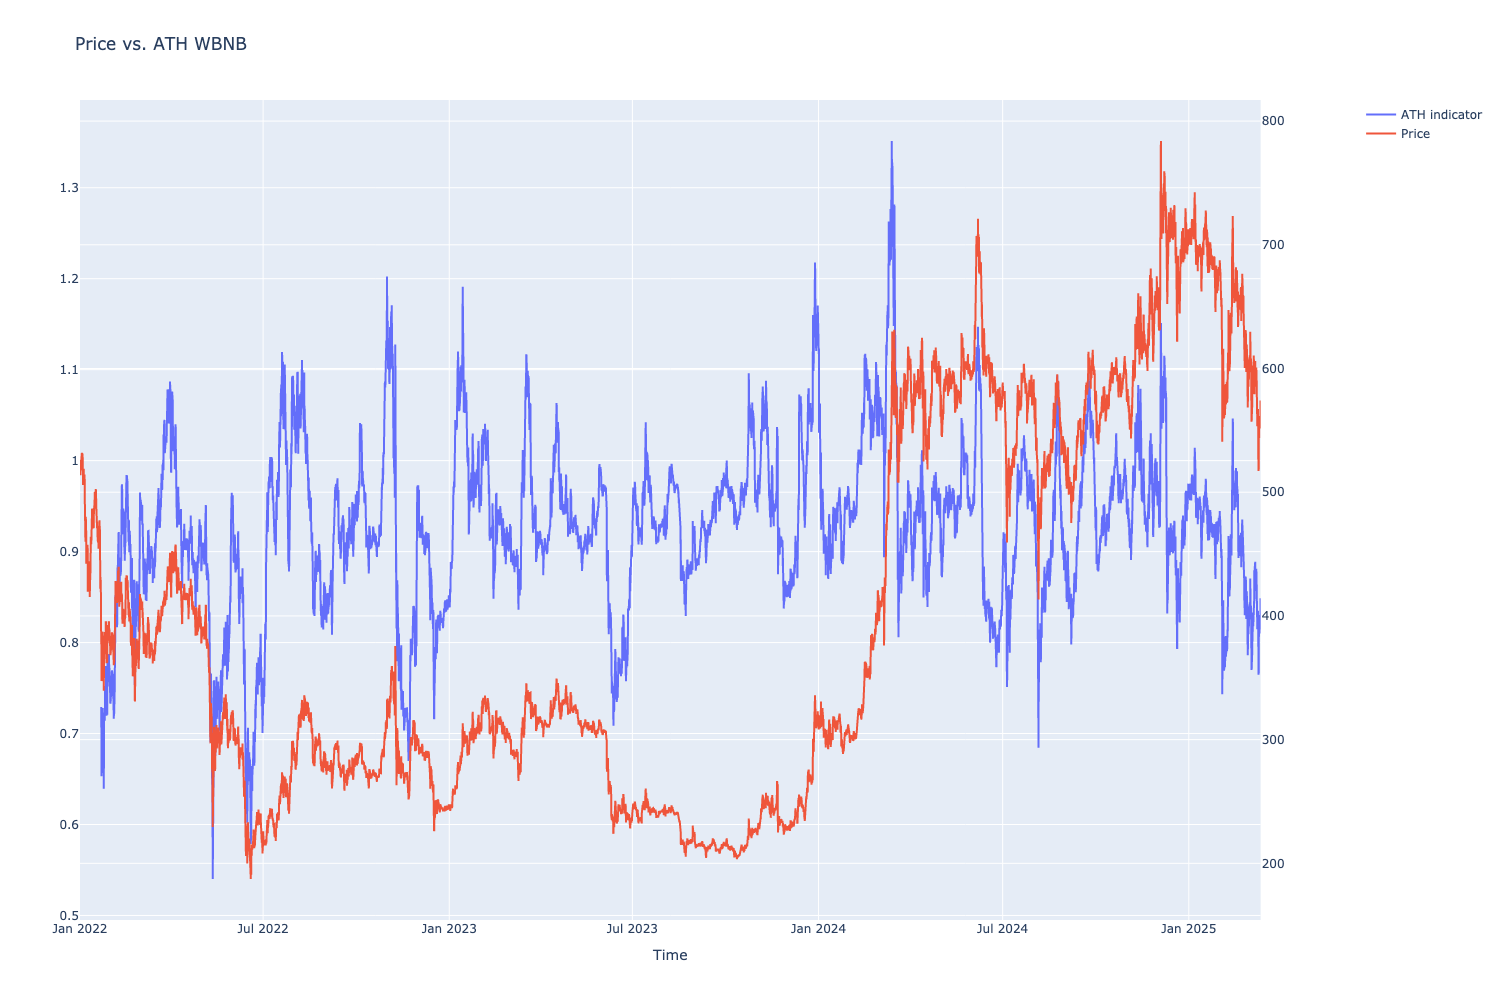

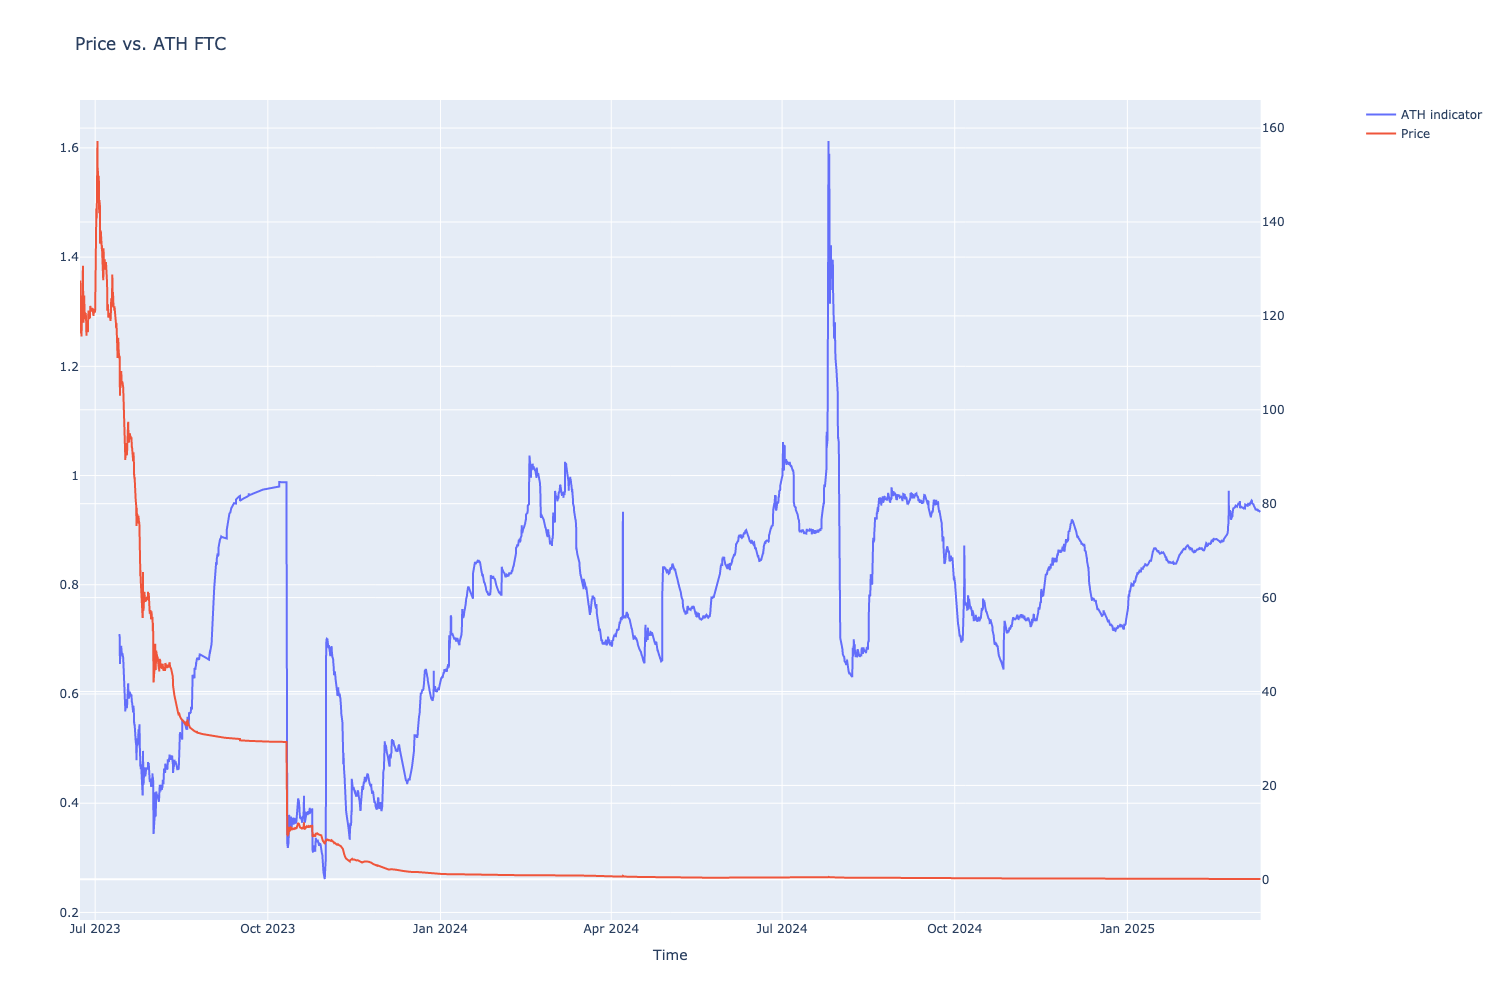

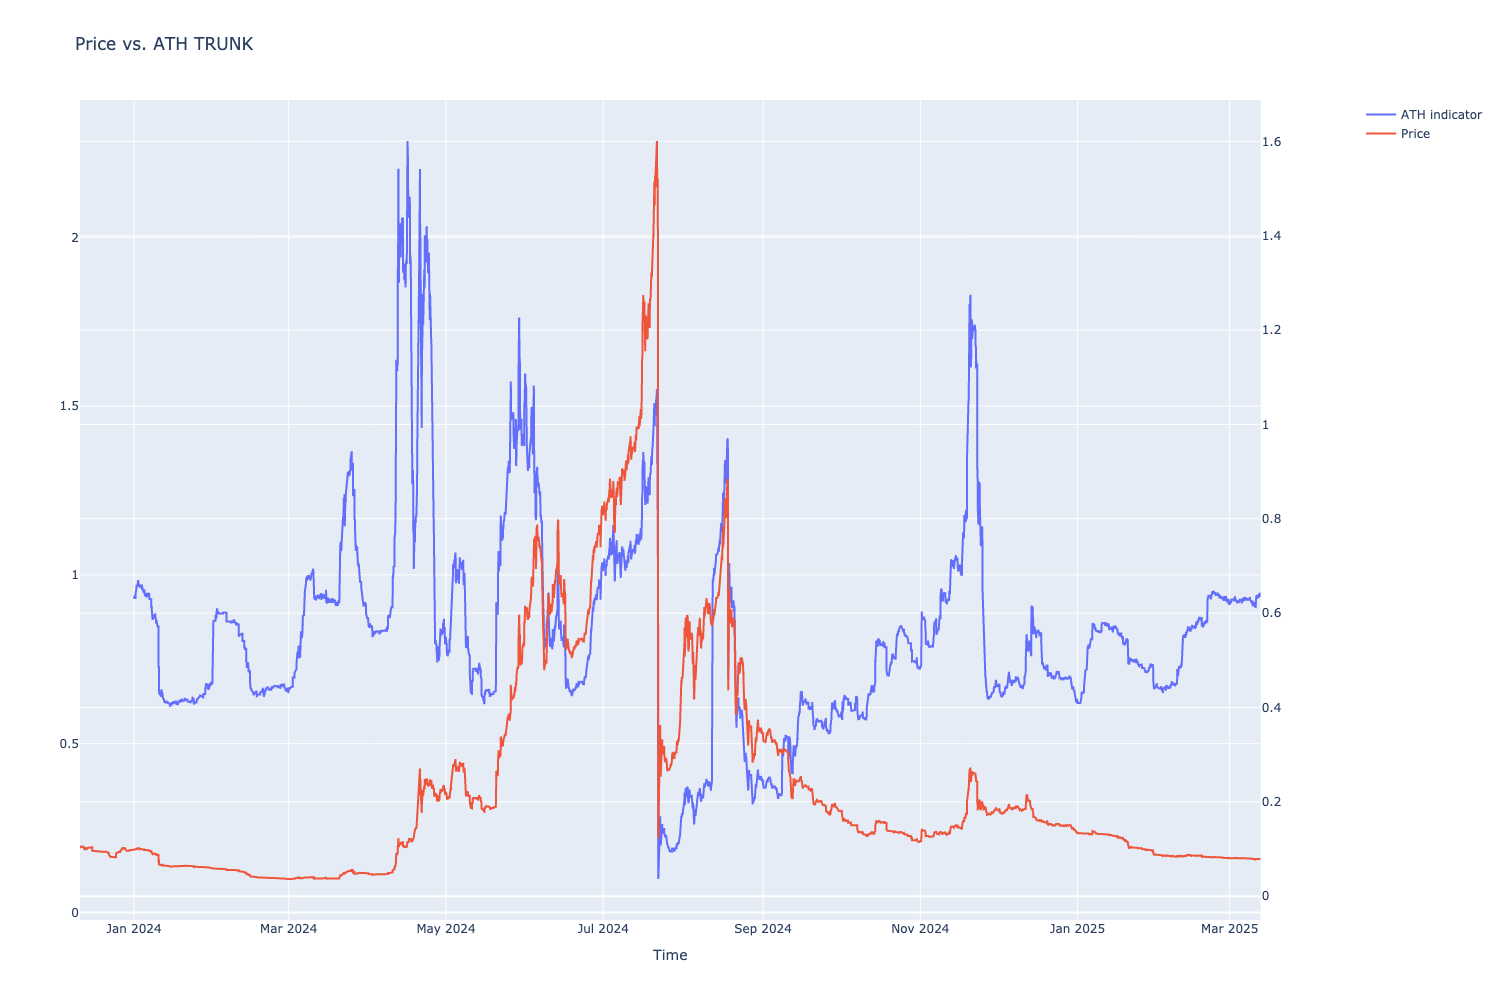

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("ath", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="ATH indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. ATH {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. daily RSI

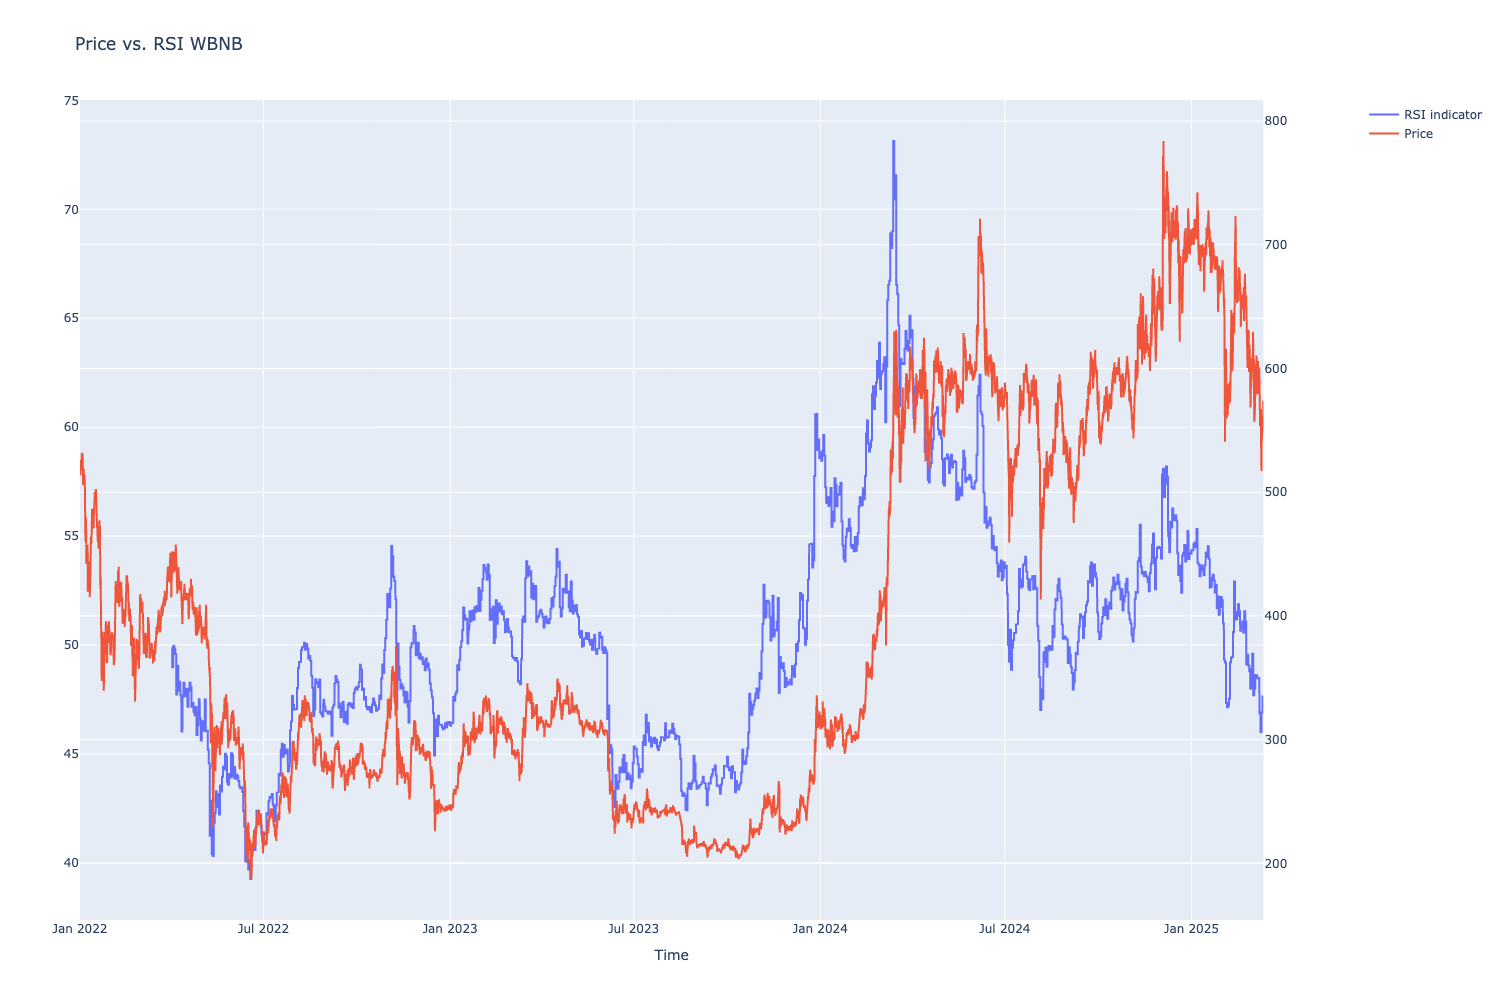

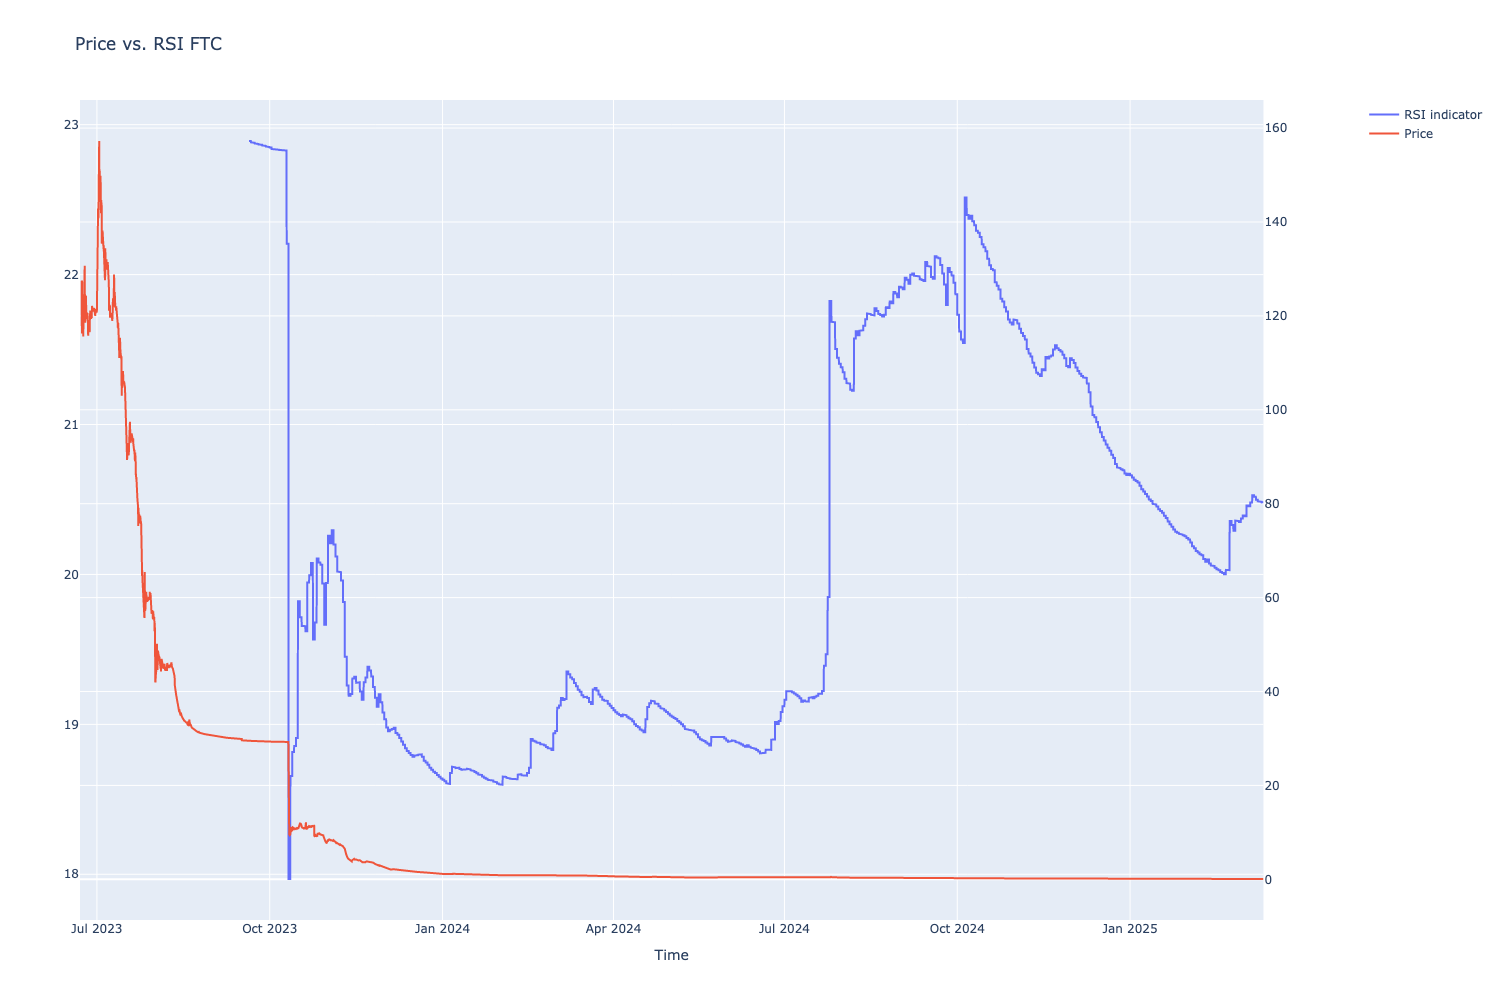

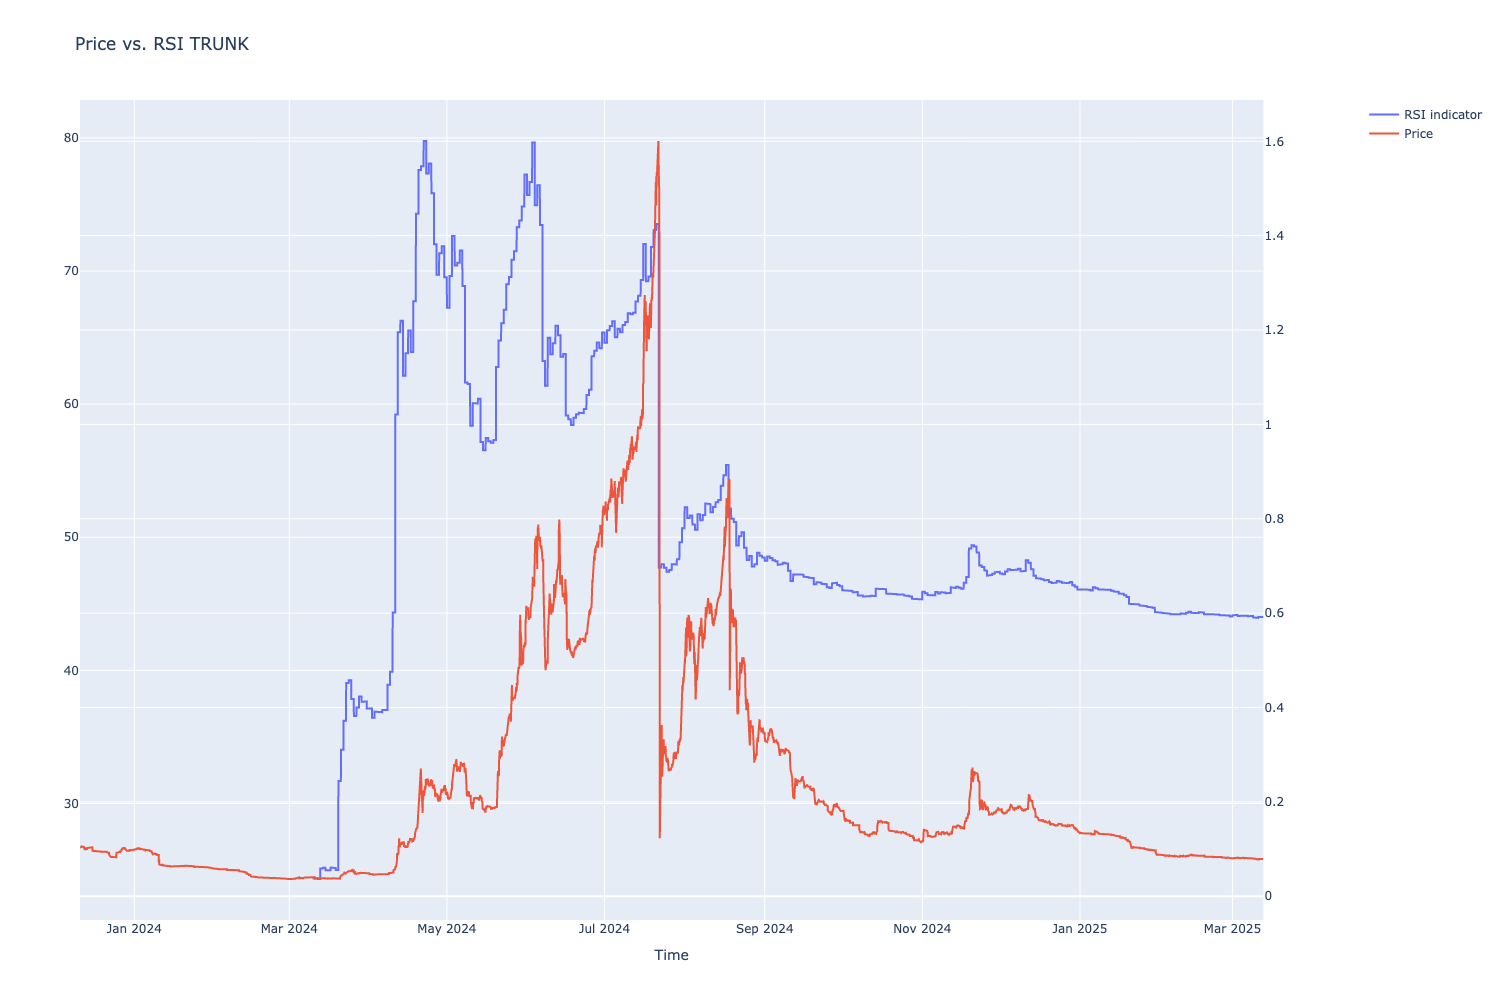

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("daily_rsi", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df["signal"] = df["signal"].ffill()

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="RSI indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. RSI {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [64]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2022-01-01 00:00:00 - 2025-03-13 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [65]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []
    
    # Set signal for each pair
    signal_count = 0  
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal 

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    credit_trades = []
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )        
        if abs(credit_deposit_flow) > parameters.credit_flow_dust_threshold:
            credit_trades = position_manager.manage_credit_flow(credit_deposit_flow)
            trades += credit_trades
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Credit trades: {credit_trades}
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators ath, volatility, rolling_cumulative_volume, rolling_liquidity_avg, volume_inclusion_…

Using indicator cache /Users/moo/.cache/indicators/binance_1h_201_2022-01-01-2025-03-13_ff


  0%|          | 0/100828800 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 4654 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [66]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
    asset_count=6,
)

Strategy                  BNB  \
Start Period                        2022-01-01           2022-01-01   
End Period                          2025-03-12           2025-03-12   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           41.0%                98.0%   
Cumulative Return                      171.99%               48.75%   
CAGR﹪                                   24.14%                8.96%   
Sharpe                                    1.26                  0.5   
Prob. Sharpe Ratio                      99.28%               81.63%   
Smart Sharpe                              1.25                  0.5   
Sortino                                   2.37                 0.73   
Smart Sortino                             2.35                 0.72   
Sortino/√2                                1.68                 0.51   
Smart Sortino/√2                          1.66                 0.51   
Omega                                     1.42                 1.42   
Max Drawdown                           -18.72%              -56.39%   
Longest DD Days                            388                  705   
Volatility (ann.)                       27.88%               57.85%   
Calmar                                    1.29                 0.16   
Skew                                      2.75                -0.05   
Kurtosis                                 25.21                 4.29   
Expected Daily                           0.09%                0.03%   
Expected Monthly                          2.6%                1.02%   
Expected Yearly                         28.42%               10.44%   
Kelly Criterion                         14.27%               10.26%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                      -2.3%                -4.9%   
Expected Shortfall (cVaR)                -2.3%                -4.9%   
Max Consecutive Wins                        18                    8   
Max Consecutive Losses                       7                    7   
Gain/Pain Ratio                           0.42                 0.08   
Gain/Pain (1M)                            1.54                 0.58   
Payoff Ratio                               1.5                 1.13   
Profit Factor                             1.42                 1.08   
Common Sense Ratio                        1.89                 1.15   
CPC Index                                 1.03                 0.64   
Tail Ratio                                1.33                 1.07   
Outlier Win Ratio                        15.39                 3.73   
Outlier Loss Ratio                        3.33                 2.78   
MTD                                      2.21%                -8.5%   
3M                                      -1.63%              -17.92%   
6M                                      -2.22%                6.88%   
YTD                                      1.93%              -21.81%   
1Y                                      34.21%                6.68%   
3Y (ann.)                               29.32%                6.82%   
5Y (ann.)                               24.14%                8.96%   
10Y (ann.)                              24.14%                8.96%   
All-time (ann.)                         24.14%                8.96%   
Best Day                                 15.7%               16.22%   
Worst Day                               -8.42%              -16.64%   
Best Month                              79.51%               44.82%   
Worst Month                             -6.81%              -31.89%   
Best Year                              102.32%              121.33%   
Worst Year                               1.93%              -33.69%   
Avg. Drawdown                           -6.41%              -16.63%   
Avg. Drawdown Days                          52                  111   
Recovery Factor                            6.0                

# Equity curve

- Equity curve shows how your strategy accrues value over time

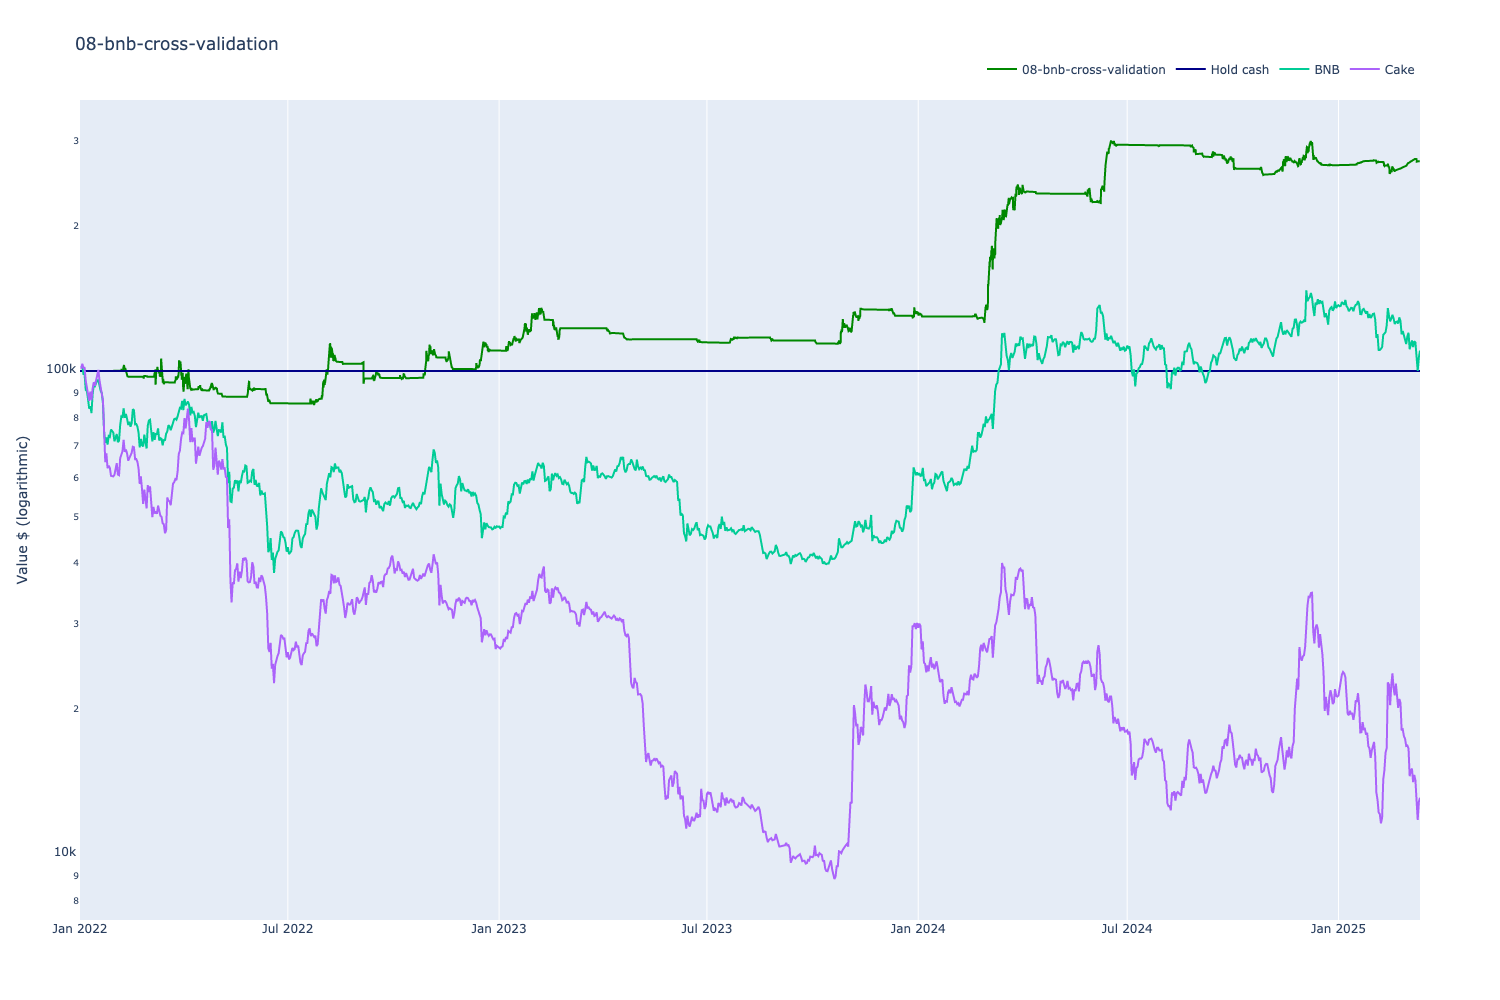

In [67]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WBNB", "Cake"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

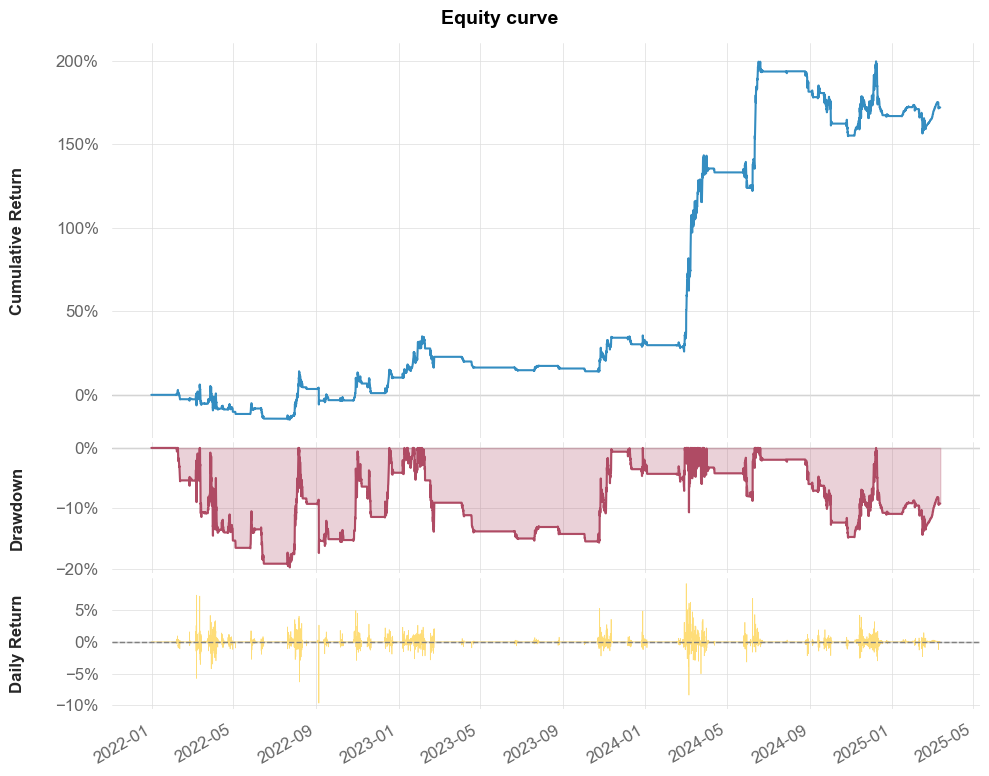

In [68]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

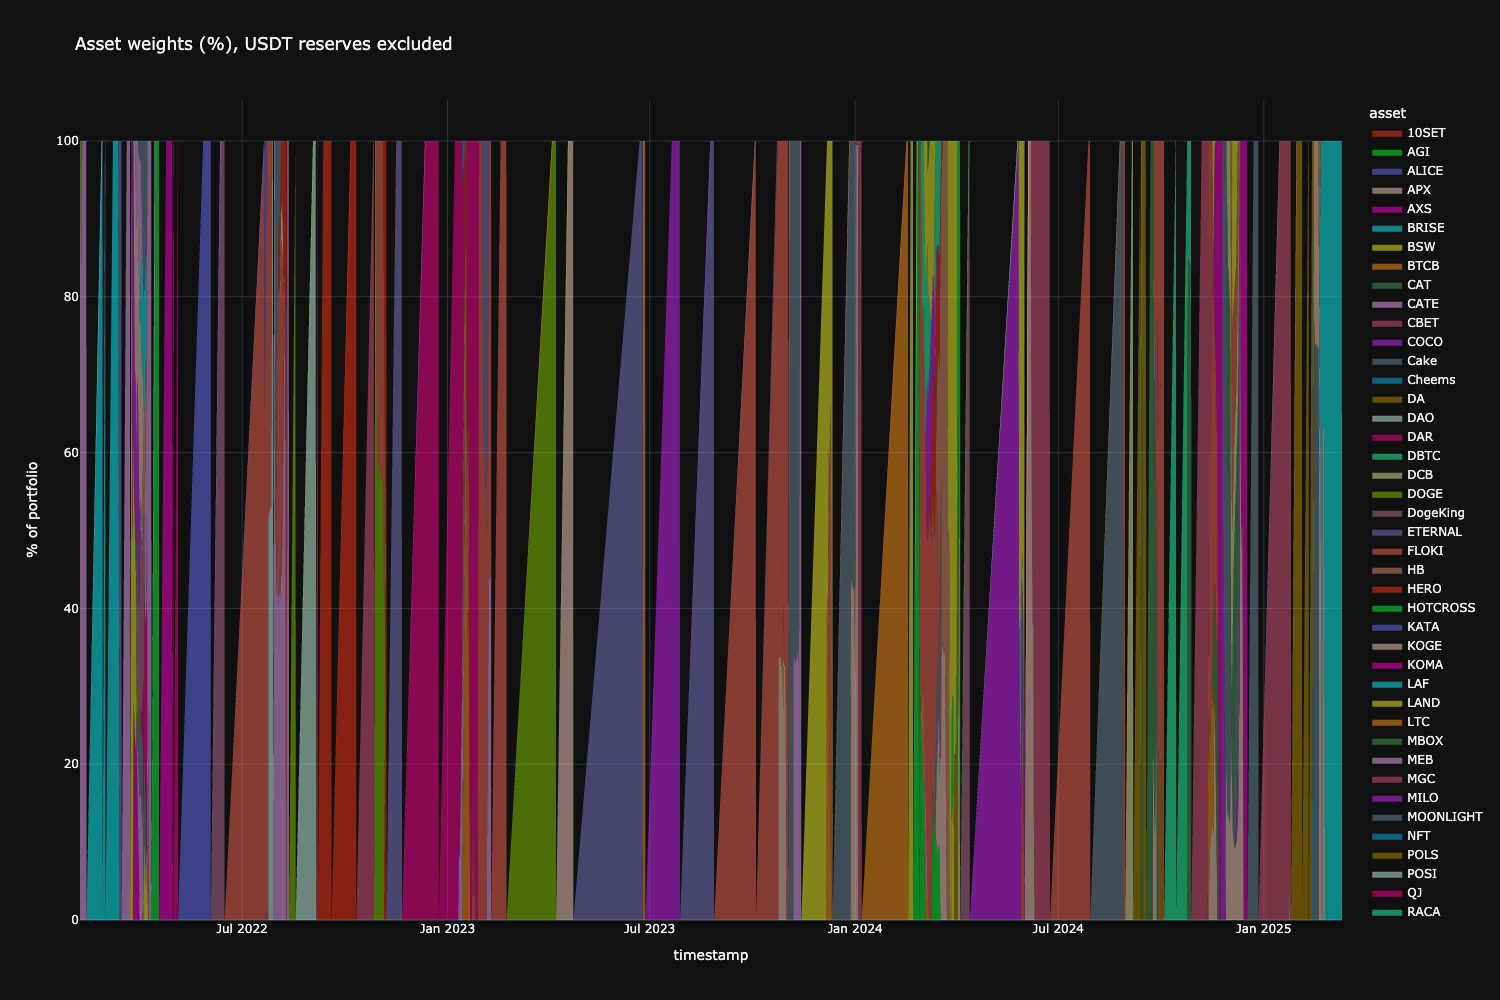

In [69]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

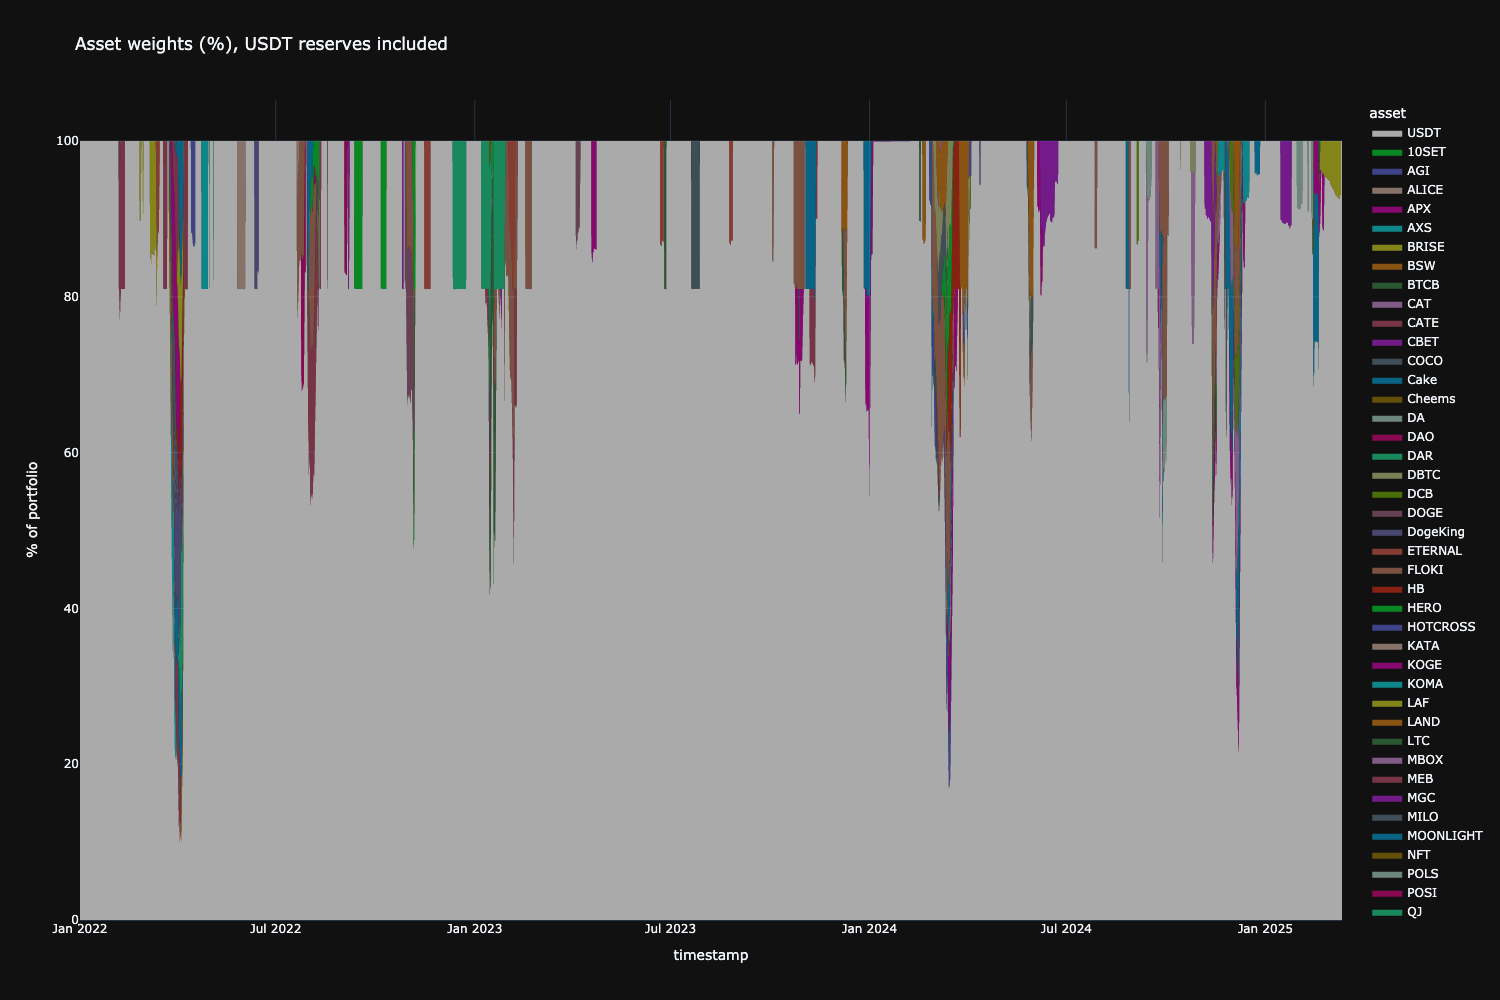

In [70]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

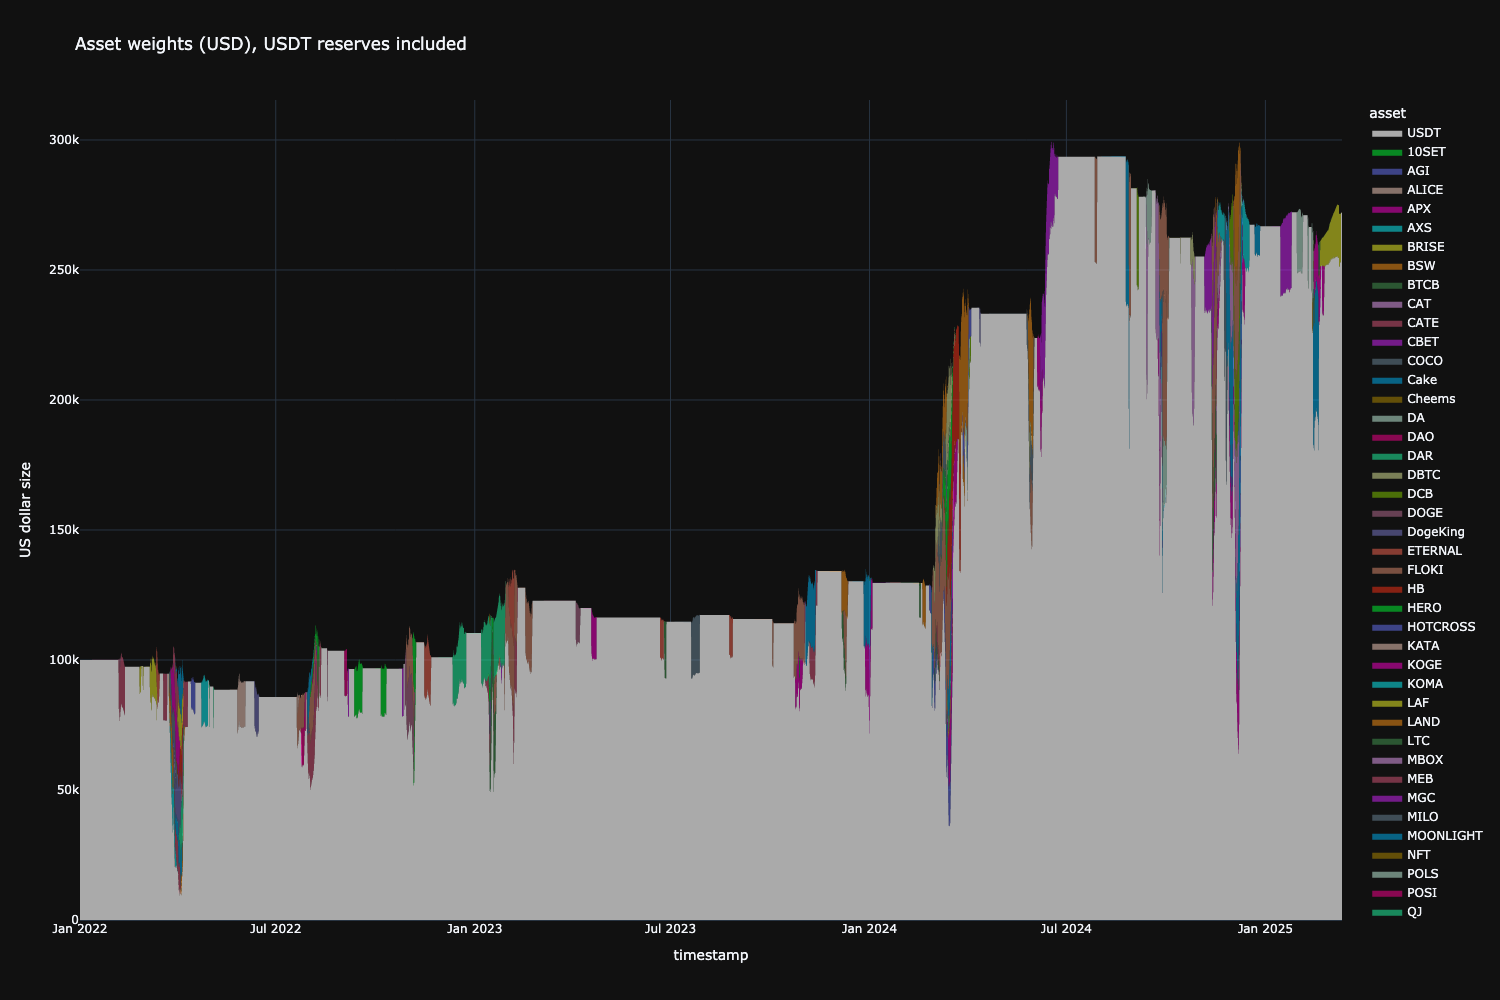

In [71]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [72]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At  Pair      Value Unit
Name                                                                     
Max position (excluding USDT)   2024-09-25 08:00:00   CAT  64,208.68  USD
Min position (excluding USDT)   2024-01-02 08:00:00  CBET      99.50  USD
Mean position (excluding USDT)                             18,951.09  USD
Max position (excluding USDT)   2022-02-05 20:00:00  CATE     100.00    %
Min position (excluding USDT)   2024-03-09 16:00:00    HB       0.50    %
Mean position (excluding USDT)                                 48.88    %
Max position (including USDT)   2022-01-01 00:00:00  USDT     100.00    %
Min position (including USDT)   2024-01-02 12:00:00  CBET       0.08    %
Mean position (including USDT)                                 57.41    %

# Positions at the end

Some example positions at the end


In [73]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [74]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [75]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Empty DataFrame
Columns: []
Index: []

# Trading pair breakdown

- Trade success for each trading pair



In [76]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [77]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Interest accrued

In [78]:
from tradeexecutor.analysis.credit import calculate_credit_metrics

interest_df = calculate_credit_metrics(state)
display(interest_df)

Value
Name                        
Credit position count      0

# Examine single pair

- Show trades taken against a single pair

We have total 0 trades on <Pair WBNB-USDT spot_market_hold at 0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae (0.2500% fee) on exchange pancakeswap-v2>


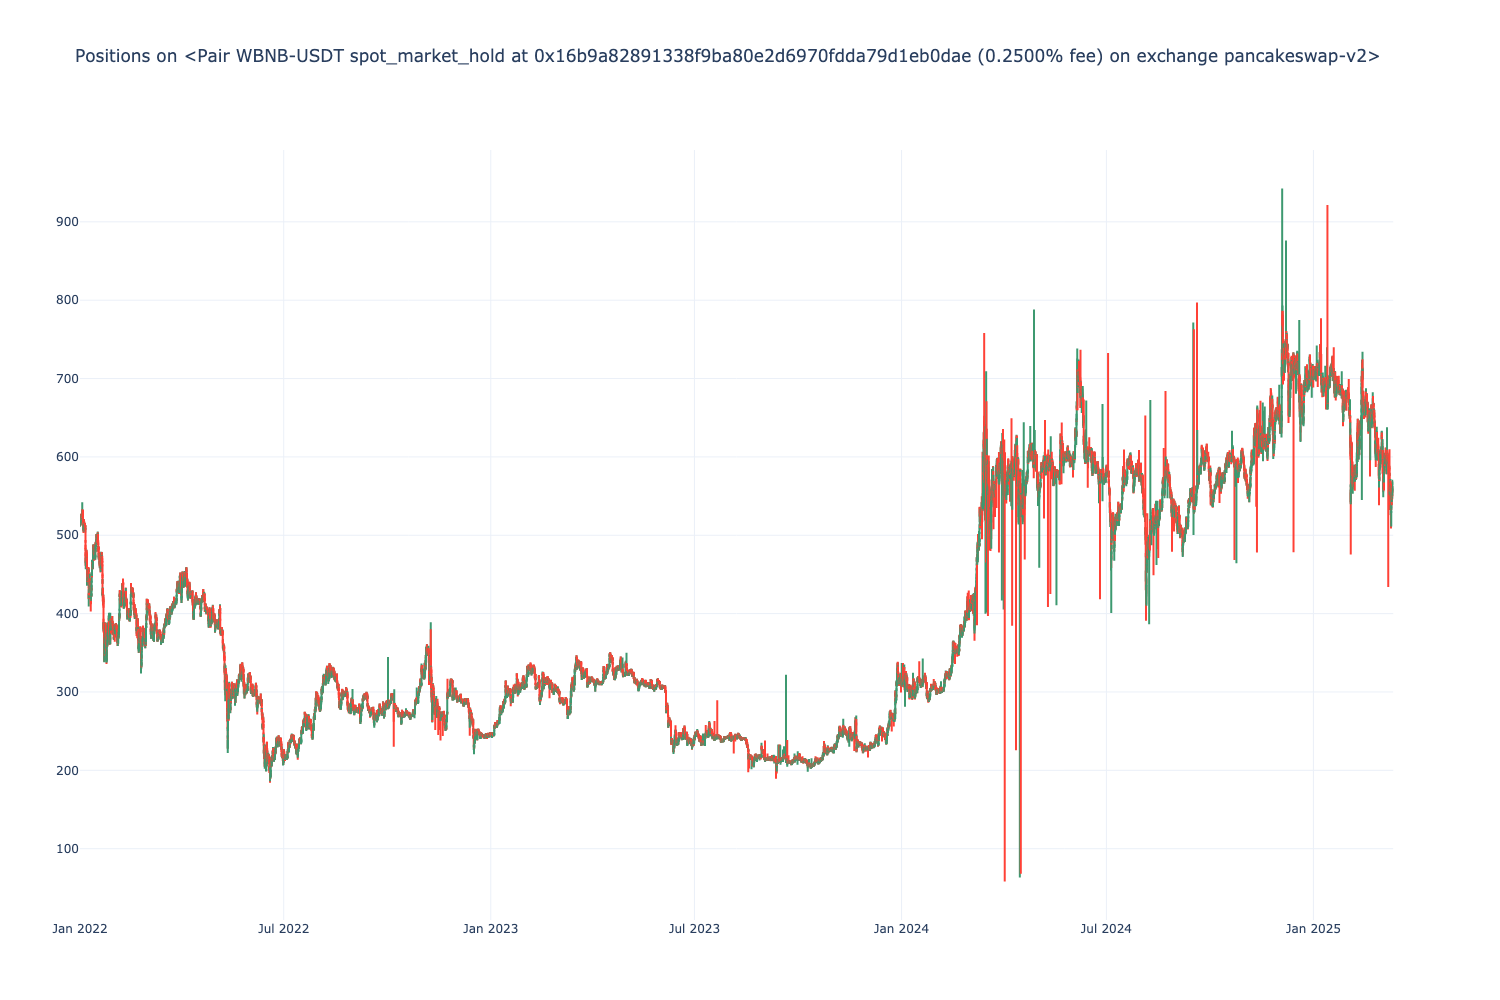

In [79]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

pair = token_map[EXAMINED_ASSETS[0]]  # Get previously resolved trading pair

all_trades = [t for t in state.portfolio.get_all_trades() if t.pair == pair]
print(f"We have total {len(all_trades)} trades on {pair}")

# start = datetime.datetime(2023, 2, 1)
# end = datetime.datetime(2023, 4, 1)

start = None
end = None

signal = indicator_data.get_indicator_series("signal", pair=pair)

figure = visualise_single_pair_positions_with_duration_and_slippage(
    state=state,
    candles=strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id),
    pair_id=pair.internal_id,
    execution_context=notebook_execution_context,
    title=f"Positions on {pair}",
    start_at=start,
    end_at=end,
)


figure.show()

## Examine positions

In [80]:
from tradeexecutor.visual.single_pair import display_positions_table
display_positions_table(state, pair, sort_by="PnL USD", ascending=True)

Empty DataFrame
Columns: []
Index: []